In [ ]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from dotenv import load_dotenv

# Set up plotting style
plt.style.use('default')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)

# Load environment variables from .env file
load_dotenv()

# Set Up Database Connection from environment variables
DB_CONFIG = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT")
}

In [ ]:
db_set = False
if DB_CONFIG["host"] is not None:
    db_set = True
    print("Database configuration loaded successfully")
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("✅ Database connection established")
    except Exception as e:
        print(f"❌ Connection error: {e}")
else:
    print("Database configuration not found. using CSV.") 


def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    sns.histplot(data.dropna(), bins=bins, alpha=0.7, edgecolor='black', ax=ax1, palette='deep')
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    sns.boxplot(y=data.dropna(), ax=ax2, palette='deep')
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


# Get data from DB and discard false data

In [ ]:
# Query for detailed round outcomes
if db_set:

    query_detailed = """
    WITH round_equipment AS (
        SELECT 
            r.id,
            r.match_id,
            r.id_demo_exports,
            r.round_num,
            r.ct_winner,
            r.team1_winner,
            r.is_ct_t1,
            r.round_end_reason,
            -- CT team equipment
            SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
            -- T team equipment
            SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
            r.t1_score_end,
            r.t2_score_end,
            r.t1_score_start,
            r.t2_score_start,
            hmi.team_1_id,
            hmi.team_2_id,
            hmi.event_id
        FROM rounds_ed r
        JOIN player_round_ed pr ON r.id = pr.round_id
        LEFT JOIN hltv_match_info hmi ON r.match_id = hmi.match_id
        WHERE pr.eq_val_fte > 0
        GROUP BY 1,2,3,4,5,6,7,8, 11,12,13, 14,15,16,17
    ),
    bomb_planted AS (
        SELECT 
            round_id,
            CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
        FROM bomb_events_round_ed
        WHERE bomb_event_type = 0
        GROUP BY round_id
    ),
    round_survivors AS (
        SELECT 
            r.id as round_id,
            r.is_ct_t1,
            -- Count total players per team (5 players each)
            -- CT survivors = 5 - (deaths of CT players)
            5 - COUNT(DISTINCT CASE 
                WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
            END) as ct_survivors,
            -- T survivors = 5 - (deaths of T players)
            5 - COUNT(DISTINCT CASE 
                WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
            END) as t_survivors
        FROM rounds_ed r
        LEFT JOIN kills_round_ed k ON r.id = k.round_id
        LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id and pv.player_id != 0
        GROUP BY 1,2
    ),
    saved_equipment AS (
        SELECT 
            r.id as round_id,
            r.is_ct_t1,
            -- CT team saved equipment from player_economy_ed joined with player_round_ed
            SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
            SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.starting_eq_val, 0) ELSE 0 END) as ct_starting_equipment,
            -- T team saved equipment from player_economy_ed joined with player_round_ed
            SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment,
            SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.starting_eq_val, 0) ELSE 0 END) as t_starting_equipment
        FROM rounds_ed r
        JOIN player_economy_ed pe ON r.id = pe.round_id
        JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
        GROUP BY 1,2
    ),
    team_money AS (
        SELECT 
            r.id as round_id,
            r.is_ct_t1,
            -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND (pe.money_earned = 0 OR pe.money_earned IS NULL) THEN 1 END) > 0 
                OR SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN 1 ELSE 0 END) = 0
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_earned ELSE 0 END) 
            END as ct_money_earned,
            -- CT team player money at start 
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND (pe.money_start = 0 OR pe.money_start IS NULL) THEN 1 END) > 0 
                OR SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN 1 ELSE 0 END) = 0
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_start ELSE 0 END) 
            END as ct_money_start,
            -- CT team player money spent (no zero check)
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND pe.money_spent IS NULL THEN 1 END) > 0 
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_spent ELSE 0 END) 
            END as ct_money_spent,
            -- T team player money (money_earned + money_earned_re) joined with player_round_ed
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND (pe.money_earned = 0 OR pe.money_earned IS NULL) THEN 1 END) > 0 
                OR SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN 1 ELSE 0 END) = 0
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_earned ELSE 0 END) 
            END as t_money_earned,
            -- T team player money at start 
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND (pe.money_start = 0 OR pe.money_start IS NULL) THEN 1 END) > 0 
                OR SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN 1 ELSE 0 END) = 0
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_start ELSE 0 END) 
            END as t_money_start,
            -- T team player money spent (no zero check)
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND pe.money_spent IS NULL THEN 1 END) > 0 
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_spent ELSE 0 END) 
            END as t_money_spent
        FROM rounds_ed r
        JOIN player_economy_ed pe ON r.id = pe.round_id
        JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
        GROUP BY 1,2
    ),
    ranked_data AS (
        SELECT 
            trd.id,
            trd.id_demo_exports,
            trd.round_num,
            trd.team1_winner,
            -- Team 1 metrics
            COALESCE(CAST(het1.rank_during AS INTEGER), 999) as t1_rank,
            -- Team 2 metrics
            COALESCE(CAST(het2.rank_during AS INTEGER), 999) as t2_rank
        FROM round_equipment trd
        LEFT JOIN hltv_events_teams het1 ON het1.team_id = trd.team_1_id AND het1.event_id = trd.event_id
        LEFT JOIN hltv_events_teams het2 ON het2.team_id = trd.team_2_id AND het2.event_id = trd.event_id
    ),
    previous_round_stats AS (
        SELECT 
            r.id as round_id,
            r.id_demo_exports,
            r.round_num,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as ct_prev_kills,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as t_prev_kills,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as ct_prev_assists,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as t_prev_assists,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as ct_prev_deaths,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as t_prev_deaths
        FROM rounds_ed r
        LEFT JOIN rounds_ed r_prev ON r.id_demo_exports = r_prev.id_demo_exports 
            AND r_prev.round_num = r.round_num - 1 
            AND r.round_num > 1
        LEFT JOIN player_round_ed pr_prev ON r_prev.id = pr_prev.round_id AND pr_prev.player_id != 0
        GROUP BY 1,2,3
    ),
    streaks as (
        SELECT 
        rse.round_id,
        rse.id_demo_exports,
        rse.round_num,
        rse.t1_win_streak,
        rse.t1_loss_streak,
        rse.t1_win_streak_cons,
        rse.t1_loss_streak_cons,
        rse.t2_win_streak,
        rse.t2_loss_streak,
        rse.t2_win_streak_cons,
        rse.t2_loss_streak_cons,
        COALESCE(rse.t1_win_streak, 0) as t1_win_streak_prev,
        COALESCE(rse.t1_loss_streak, 0) as t1_loss_streak_prev,
        COALESCE(rse.t1_win_streak_cons, 0) as t1_win_streak_cons_prev ,
        COALESCE(rse.t1_loss_streak_cons, 0) as t1_loss_streak_cons_prev ,
        COALESCE(rse.t2_win_streak, 0) as t2_win_streak_prev,
        COALESCE(rse.t2_loss_streak, 0) as t2_loss_streak_prev,
        COALESCE(rse.t2_win_streak_cons, 0) as t2_win_streak_cons_prev,
        COALESCE(rse.t2_loss_streak_cons, 0) as t2_loss_streak_cons_prev
        FROM round_streaks_ed rse
        -- loockback part
        LEFT JOIN round_streaks_ed rse_prev ON rse.id_demo_exports = rse_prev.id_demo_exports 
            AND rse_prev.round_num = rse.round_num - 1 
            AND rse.round_num > 1
    )

    SELECT 
        re.*,
        -- Add bomb planted status
        COALESCE(bp.bomb_planted, 0) as bomb_planted,
        -- Add survivor counts from round_survivors CTE
        rs.ct_survivors,
        rs.t_survivors,
        -- Higher and lower equipment
        CASE 
            WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
            ELSE re.t_equipment
        END as higher_equipment,
        CASE 
            WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
            ELSE re.t_equipment
        END as lower_equipment,
        -- Did higher equipment team win?
        CASE 
            WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
            OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
            THEN 1
            ELSE 0
        END as higher_eq_won,
        -- Winner's survivors (only from is_alive_re)
        CASE 
            WHEN re.ct_winner THEN rs.ct_survivors
            ELSE rs.t_survivors
        END as winner_survivors,
        -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
        CASE 
            WHEN re.ct_winner THEN se.ct_saved_equipment
            ELSE se.t_saved_equipment
        END as winner_saved_equipment,
        -- CT and T saved equipment 
        se.ct_saved_equipment,
        se.ct_starting_equipment,
        se.t_saved_equipment,
        se.t_starting_equipment,
        -- All money columns for analysis
        tm.ct_money_earned,
        tm.ct_money_start,
        tm.ct_money_spent,
        tm.t_money_earned,
        tm.t_money_start,
        tm.t_money_spent,
        -- Previous round stats
        prs.ct_prev_kills,
        prs.t_prev_kills,
        prs.ct_prev_assists,
        prs.t_prev_assists,
        prs.ct_prev_deaths,
        prs.t_prev_deaths,
        -- Ranked data
        rd.t1_rank,
        rd.t2_rank,
        -- streaks data
        st.t1_win_streak,
        st.t1_loss_streak,
        st.t1_win_streak_cons,
        st.t1_loss_streak_cons,
        st.t2_win_streak,
        st.t2_loss_streak,
        st.t2_win_streak_cons,
        st.t2_loss_streak_cons,
        st.t1_win_streak_prev, 
        st.t1_loss_streak_prev, 
        st.t1_win_streak_cons_prev, 
        st.t1_loss_streak_cons_prev, 
        st.t2_win_streak_prev, 
        st.t2_loss_streak_prev, 
        st.t2_win_streak_cons_prev, 
        st.t2_loss_streak_cons_prev
    FROM round_equipment re
    LEFT JOIN bomb_planted bp ON re.id = bp.round_id
    LEFT JOIN round_survivors rs ON re.id = rs.round_id
    LEFT JOIN saved_equipment se ON re.id = se.round_id
    LEFT JOIN previous_round_stats prs ON re.id = prs.round_id
    LEFT JOIN team_money tm ON re.id = tm.round_id
    LEFT JOIN ranked_data rd ON re.id = rd.id
    LEFT JOIN streaks st ON re.id = st.round_id
    WHERE re.ct_equipment > 0 AND re.t_equipment > 0 
    ORDER BY re.id_demo_exports, re.round_num
    """

    print("📊 Fetching detailed round data...")
    detailed_df = pd.read_sql_query(query_detailed, conn)
    print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
    print()

    # Combine round end reasons 12 and 7
    print("🔹 Pre-processing: Combining round end reasons 12 and 7")
    detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
    print(f"   Round end reasons 12 merged into 7")
    print()

    # Recode round end reasons: 1→1, 9→2, 7→3, 8→4
    print("🔹 Recoding round end reasons")
    original_count = len(detailed_df)
    print(f"   Original distribution:")
    for old_code in [1, 7, 8, 9]:
        count = (detailed_df['round_end_reason'] == old_code).sum()
        pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
        print(f"      Reason {old_code}: {count:,} rounds ({pct:.2f}%)")

    detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({
        1: 1,  # T Win (Target Bombed) - no change
        9: 2,  # T Win (Elimination) - 9 → 2
        7: 3,  # CT Win (Defuse) - 7 → 3
        8: 4,  # CT Win (Elimination) - 8 → 4
    })

    print(f"   New distribution:")
    for new_code in [1, 2, 3, 4]:
        count = (detailed_df['round_end_reason'] == new_code).sum()
        pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
        print(f"      Reason {new_code}: {count:,} rounds ({pct:.2f}%)")
    print()



📊 Fetching detailed round data...


C:\Users\peter\AppData\Local\Temp\ipykernel_32868\2950286755.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_df = pd.read_sql_query(query_detailed, conn)


✅ Loaded 2,601,592 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7

🔹 Recoding round end reasons
   Original distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 7: 405,067 rounds (15.57%)
      Reason 8: 934,538 rounds (35.92%)
      Reason 9: 854,541 rounds (32.85%)
   New distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 2: 854,541 rounds (32.85%)
      Reason 3: 405,067 rounds (15.57%)
      Reason 4: 934,538 rounds (35.92%)



# Export of the original Query for Replication in csv format
If the notebook is to be replicated outside of the DB environment, use the provided CSV from this point on

In [ ]:
if db_set:
    # Export the detailed_df dataframe to CSV
    from datetime import datetime

    # Create filename with current date
    export_date = datetime.now().strftime('%Y%m%d')
    csv_filename = f'abm_distributions_{export_date}.csv'

    # Export to CSV
    detailed_df.to_csv(csv_filename, index=False)

    print(f"✅ Data exported to: {csv_filename}")
    print(f"   Rows: {len(detailed_df):,}")
    print(f"   Columns: {len(detailed_df.columns)}")
    print(f"   Column names: {', '.join(detailed_df.columns.tolist())}")

✅ Data exported to: abm_distributions_20260213.csv
   Rows: 2,601,592
   Columns: 59
   Column names: id, match_id, id_demo_exports, round_num, ct_winner, team1_winner, is_ct_t1, round_end_reason, ct_equipment, t_equipment, t1_score_end, t2_score_end, t1_score_start, t2_score_start, team_1_id, team_2_id, event_id, bomb_planted, ct_survivors, t_survivors, higher_equipment, lower_equipment, higher_eq_won, winner_survivors, winner_saved_equipment, ct_saved_equipment, ct_starting_equipment, t_saved_equipment, t_starting_equipment, ct_money_earned, ct_money_start, ct_money_spent, t_money_earned, t_money_start, t_money_spent, ct_prev_kills, t_prev_kills, ct_prev_assists, t_prev_assists, ct_prev_deaths, t_prev_deaths, t1_rank, t2_rank, t1_win_streak, t1_loss_streak, t1_win_streak_cons, t1_loss_streak_cons, t2_win_streak, t2_loss_streak, t2_win_streak_cons, t2_loss_streak_cons, t1_win_streak_prev, t1_loss_streak_prev, t1_win_streak_cons_prev, t1_loss_streak_cons_prev, t2_win_streak_prev, t2_lo

In [ ]:
if not db_set:
    csv_filename = f'DB_Data.csv'
    detailed_df = pd.read_csv(csv_filename)

In [6]:


# Filter out inconsistent data
# Reason 2 (T Win Elimination - was 9) should have CT survivors = 0
filtered_9 = (detailed_df['round_end_reason'] == 2) & (detailed_df['ct_survivors'] > 0)

# Find last round of each game
last_round_per_game = detailed_df.groupby('id_demo_exports')['round_num'].max()
is_last_round = detailed_df['round_num'] == detailed_df['id_demo_exports'].map(last_round_per_game)

# Separate last rounds from others
is_last_round_issue = filtered_9 & is_last_round
is_other_issue = filtered_9 & ~is_last_round

reason_9_issues = detailed_df[filtered_9]
print(f"🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:")
print(f"   Found {len(reason_9_issues):,} rounds where Reason 2 occurred but CT had survivors > 0")

# Correct ct_survivors to 0 for last round inconsistencies, this can happen as the parser sometimes does not receive the death of the last player
#before the demo is ended
num_corrected = is_last_round_issue.sum()
if num_corrected > 0:
    detailed_df.loc[is_last_round_issue, 'ct_survivors'] = 0
    print(f"   Corrected ct_survivors to 0 for {num_corrected:,} last round inconsistencies")

# Filter out other inconsistencies
before = len(detailed_df)
detailed_df = detailed_df[~is_other_issue]
total_filtered = before - len(detailed_df)

print(f"   Removed: {total_filtered:,} rounds (non-last-round inconsistencies)")
print(f"   Remaining: {len(detailed_df):,} rounds")
print()
print("✅ Data quality filtering complete")

🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:
   Found 2,821 rounds where Reason 2 occurred but CT had survivors > 0
   Corrected ct_survivors to 0 for 51 last round inconsistencies
   Removed: 2,770 rounds (non-last-round inconsistencies)
   Remaining: 2,598,822 rounds

✅ Data quality filtering complete


In [7]:
#transforming rank data for ct/t side

detailed_df['ct_rank'] = detailed_df[detailed_df['is_ct_t1'] == 1]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 0]['t2_rank']
)

detailed_df['t_rank'] = detailed_df[detailed_df['is_ct_t1'] == 0]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 1]['t2_rank']
)

In [8]:
print("="*80)
print("DATAFRAME COLUMNS")
print("="*80)
print()

print(f"Total Columns: {len(detailed_df.columns)}")
print()

print("Column List:")
print("-"*80)
for i, col in enumerate(detailed_df.columns, 1):
    dtype = detailed_df[col].dtype
    non_null = detailed_df[col].notna().sum()
    null_pct = (detailed_df[col].isna().sum() / len(detailed_df)) * 100
    print(f"{i:3d}. {col:30s} | Type: {str(dtype):15s} | Non-Null: {non_null:10,d} | Null%: {null_pct:5.1f}%")

print()
print("="*80)
print("DATAFRAME INFO")
print("="*80)
print(f"Shape: {detailed_df.shape[0]:,} rows × {detailed_df.shape[1]} columns")
print(f"Memory Usage: {detailed_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

print("Data Types Summary:")
print(detailed_df.dtypes.value_counts())

DATAFRAME COLUMNS

Total Columns: 61

Column List:
--------------------------------------------------------------------------------
  1. id                             | Type: int64           | Non-Null:  2,598,822 | Null%:   0.0%
  2. match_id                       | Type: int64           | Non-Null:  2,598,822 | Null%:   0.0%
  3. id_demo_exports                | Type: int64           | Non-Null:  2,598,822 | Null%:   0.0%
  4. round_num                      | Type: int64           | Non-Null:  2,598,822 | Null%:   0.0%
  5. ct_winner                      | Type: bool            | Non-Null:  2,598,822 | Null%:   0.0%
  6. team1_winner                   | Type: bool            | Non-Null:  2,598,822 | Null%:   0.0%
  7. is_ct_t1                       | Type: bool            | Non-Null:  2,598,822 | Null%:   0.0%
  8. round_end_reason               | Type: int64           | Non-Null:  2,598,822 | Null%:   0.0%
  9. ct_equipment                   | Type: int64           | Non-Null:  2,5

In [9]:
# Analyze economy variables

detailed_df['ct_spent_ratio'] = detailed_df['ct_money_spent'] / (detailed_df['ct_money_start'] + 1)  # Avoid division by zero
detailed_df['ct_invested_ratio'] = detailed_df['ct_equipment'] / (detailed_df['ct_money_start'] + detailed_df['ct_starting_equipment'] + 1)  # Avoid division by zero
detailed_df['ct_saved_equipment_ratio'] = detailed_df['ct_saved_equipment'].replace(0, np.nan) / detailed_df['ct_survivors'].replace(0, np.nan)  # Avoid division by zero

detailed_df['t_spent_ratio'] = detailed_df['t_money_spent'] / (detailed_df['t_money_start'] + 1)  # Avoid division by zero
detailed_df['t_invested_ratio'] = detailed_df['t_equipment'] / (detailed_df['t_money_start'] + detailed_df['t_starting_equipment'] + 1)  # Avoid division by zero
detailed_df['t_saved_equipment_ratio'] = detailed_df['t_saved_equipment'].replace(0, np.nan) / detailed_df['t_survivors'].replace(0, np.nan)  # Avoid division by zero

detailed_df['ct_investment_ratio'] = detailed_df['ct_equipment'] / (detailed_df['ct_equipment'] + detailed_df['t_equipment'])  
detailed_df['ct_t_log_ratio'] = np.log(detailed_df['ct_equipment']/detailed_df['t_equipment'])

#TODO: as a quick fix while the larger problem is not solved, exclude invested ratio values over 1 (as that should not be possible). 
#There might be multiple underlying reasons for this: 
#1. players not present at RS cause values to be missed i.e. 0 which skews the sums for calculations on round start metrics
#2. other parser or demos issues (see example below)
# 
# 
# e.g. id_demo_exports 4561 (match_id 2364701) round_id 96905. there seem to have been tech issues. therefore the values at the previous round ROFE are incorrect. as well as the RS values
# the biggest issue with the previously mentioned demo is that the heuristic thinks the players respawned after being killed. actually they were respawned due to tech issues
# their correct inventory values have not been reset yet to the previous values. That's where the issue lies. cannot be fixed at this stage. issue could probably be solved at the parser level. 

#workaround fix: is to set those values to NAN, as I cannot verify them properly. should be around 400 rounds affected. 
#the good thing is, tech issues as described above, are rare and if they occur, this fix catches all of them. 
detailed_df.loc[detailed_df['ct_invested_ratio'] > 1, ['ct_invested_ratio', 'ct_money_spent', 'ct_money_start', 'ct_spent_ratio', 'ct_starting_equipment']] = np.nan
detailed_df.loc[detailed_df['t_invested_ratio'] > 1, ['t_invested_ratio', 't_money_spent', 't_money_start', 't_spent_ratio', 't_starting_equipment']] = np.nan

In [10]:


# Filter outliers: keep 99% interval (0.5% to 99.5% percentiles)
q_low_ratio = detailed_df['ct_investment_ratio'].quantile(0.005)
q_high_ratio = detailed_df['ct_investment_ratio'].quantile(0.995)
detailed_df = detailed_df[(detailed_df['ct_investment_ratio'] >= q_low_ratio) & (detailed_df['ct_investment_ratio'] <= q_high_ratio)]

# Calculate CSF based on pure Tullock Likelihood model by Peeters using MLE 

In [11]:
from scipy.optimize import minimize
from scipy.special import expit
import numpy as np

# ============================================================================
# MLE FOR TULLOCK CONTEST SUCCESS FUNCTION (CSF)
# ============================================================================

def tullock_csf(ct_eq, t_eq, r):
    """
    Tullock Contest Success Function
    P(CT wins) = CT^r / (CT^r + T^r)
    """
    ct_r = np.power(ct_eq, r)
    t_r = np.power(t_eq, r)
    return ct_r / (ct_r + t_r)

def neg_log_likelihood_tullock(params, ct_equipment, t_equipment, ct_winner):
    """
    Negative log-likelihood for Tullock CSF
    
    Likelihood = ∏ [P(CT wins)]^(ct_win) * [P(T wins)]^(1-ct_win)
    Log-likelihood = Σ [ct_win * log(P(CT wins)) + (1-ct_win) * log(P(T wins))]
    
    Parameters:
    - params: [r] - the contest intensity parameter
    - ct_equipment: array of CT equipment values
    - t_equipment: array of T equipment values
    - ct_winner: array of binary outcomes (1 if CT won, 0 if T won)
    """
    r = params[0]
    
    # Ensure r is positive
    if r <= 0:
        return 1e10
    
    # Calculate P(CT wins) for each round
    p_ct = tullock_csf(ct_equipment, t_equipment, r)
    
    # Clip probabilities to avoid log(0)
    p_ct = np.clip(p_ct, 1e-10, 1 - 1e-10)
    p_t = 1 - p_ct
    
    # Log-likelihood: sum of [y*log(p_ct) + (1-y)*log(p_t)]
    log_lik = np.sum(ct_winner * np.log(p_ct) + (1 - ct_winner) * np.log(p_t))
    
    # Return negative log-likelihood (we minimize)
    return -log_lik

# ============================================================================
# PREPARE DATA
# ============================================================================
print("="*80)
print("MAXIMUM LIKELIHOOD ESTIMATION FOR TULLOCK CSF")
print("="*80)
print()

# Extract equipment values and outcomes
ct_eq = detailed_df['ct_equipment'].values
t_eq = detailed_df['t_equipment'].values
ct_win = detailed_df['ct_winner'].values

print(f"📊 Data prepared:")
print(f"   Total rounds: {len(ct_eq):,}")
print(f"   CT wins: {ct_win.sum():,} ({ct_win.mean()*100:.2f}%)")
print(f"   T wins: {(1-ct_win).sum():,} ({(1-ct_win).mean()*100:.2f}%)")
print()

# ============================================================================
# OPTIMIZE TO FIND OPTIMAL r
# ============================================================================
print("Running Maximum Likelihood Estimation...")
print("-" * 80)

# Initial guess for r
r0 = [1.0]

# Run optimization
result_mle = minimize(
    neg_log_likelihood_tullock,
    r0,
    args=(ct_eq, t_eq, ct_win),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True}
)

# Extract results
r_optimal = result_mle.x[0]
neg_ll = result_mle.fun
log_likelihood = -neg_ll

print()
print("="*80)
print("MLE RESULTS - TULLOCK CSF")
print("="*80)
print(f"Optimal r parameter: {r_optimal:.6f}")
print(f"Log-Likelihood: {log_likelihood:.2f}")
print(f"Negative Log-Likelihood: {neg_ll:.2f}")
print(f"Optimization converged: {result_mle.success}")
print(f"Iterations: {result_mle.nit}")
print()


MAXIMUM LIKELIHOOD ESTIMATION FOR TULLOCK CSF

📊 Data prepared:
   Total rounds: 2,572,971
   CT wins: 1,326,611 (51.56%)
   T wins: 1,246,360 (48.44%)

Running Maximum Likelihood Estimation...
--------------------------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 1508185.025616
         Iterations: 12
         Function evaluations: 24

MLE RESULTS - TULLOCK CSF
Optimal r parameter: 1.090723
Log-Likelihood: -1508185.03
Negative Log-Likelihood: 1508185.03
Optimization converged: True
Iterations: 12



In [12]:
# Calculate predicted CT win probability with optimal r
detailed_df['predicted_win_prob'] = (
    np.power(detailed_df['ct_equipment'], r_optimal) / 
    (np.power(detailed_df['ct_equipment'], r_optimal) + 
     np.power(detailed_df['t_equipment'], r_optimal))
)


# Round End Reason Prediction Model

We'll analyze how round end reasons vary with CSF advantage. This helps the ABM predict realistic round outcomes based on equipment advantage.

In [13]:
print("="*80)
print("📊 ROUND END REASON DISTRIBUTION BY CSF PERCENTAGE (CT & T SIDES)")
print("="*80)
print()

# Get top 4 round end reasons
top_reasons = detailed_df['round_end_reason'].value_counts().head(4).index.tolist()
reason_names = {
    1: "T Win (Target Bombed)",
    2: "T Win (Elimination)",
    3: "CT Win (Target Saved)",
    4: "CT Win (Elimination)",
}

print("Top 4 Round End Reasons:")
for reason in top_reasons:
    reason_name = reason_names.get(reason, f"Reason {reason}")
    count = (detailed_df['round_end_reason'] == reason).sum()
    pct = count / len(detailed_df) * 100
    print(f"   {reason}: {reason_name} - {count:,} rounds ({pct:.2f}%)")
print()

# Create CSF percentage bins (0-100% in steps)
csf_bins = np.arange(0, 1.01, 0.01)  # 0%, 1%, 2%, ..., 100%
csf_labels = [f"{int(i*100)}" for i in csf_bins[:-1]]

detailed_df['csf_pct_bin'] = pd.cut(detailed_df['predicted_win_prob'], 
                                     bins=csf_bins, 
                                     labels=csf_labels,
                                     include_lowest=True,
                                     ordered=False)

# Analyze round end reason distributions by CSF percentage for CT and T sides
round_end_reason_analysis = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE ROUND END REASON DISTRIBUTIONS")
    print(f"{'='*80}\n")
    
    side_analysis = {}
    
    for csf_pct in range(1, 101):  # 1% to 100% CSF (CT win probability)
        df_csf = detailed_df[detailed_df['csf_pct_bin'] == str(csf_pct)].copy()
        
        if len(df_csf) < 10:
            continue
        
        # Determine which rounds this side won
        if side == 'CT':
            df_side = df_csf[df_csf['ct_winner'] == True].copy()
        else:
            df_side = df_csf[df_csf['ct_winner'] == False].copy()
        
        if len(df_side) < 5:
            continue
        
        # Calculate distribution of round end reasons for this side's wins
        reason_counts = df_side['round_end_reason'].value_counts()
        total_rounds = len(df_side)
        
        reason_dist = {}
        for reason in top_reasons:
            count = reason_counts.get(reason, 0)
            prob = count / total_rounds if total_rounds > 0 else 0
            reason_dist[reason] = {
                'count': int(count),
                'probability': float(prob),
                'reason_name': reason_names.get(reason, f"Reason {reason}")
            }
        
        side_analysis[csf_pct] = {
            'n_rounds': total_rounds,
            'reason_distribution': reason_dist
        }
    
    # Print sample at key CSF percentages
    print(f"{side} Round End Reason Distribution by CSF%:")
    print(f"{'CSF%':<6} {'N':<8} {'Reason 1':<12} {'Reason 2':<12} {'Reason 3':<12} {'Reason 4':<12}")
    print(f"{'-'*70}")
    
    for csf_pct in [10, 30, 50, 70, 90]:
        if csf_pct in side_analysis:
            data = side_analysis[csf_pct]
            reason_dist = data['reason_distribution']
            
            print(f"{csf_pct:<6} {data['n_rounds']:<8,} "
                  f"{reason_dist.get(1, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(2, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(3, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(4, {}).get('probability', 0):<12.4f}")
    
    round_end_reason_analysis[side] = side_analysis

print()
print("="*80)
print("✅ Round end reason distribution analysis complete")
print("="*80)
print()
print("💡 Use these distributions to sample round end reasons based on CSF advantage and side")


📊 ROUND END REASON DISTRIBUTION BY CSF PERCENTAGE (CT & T SIDES)

Top 4 Round End Reasons:
   4: CT Win (Elimination) - 923,305 rounds (35.88%)
   2: T Win (Elimination) - 841,615 rounds (32.71%)
   1: T Win (Target Bombed) - 404,616 rounds (15.73%)
   3: CT Win (Target Saved) - 403,435 rounds (15.68%)


🔹 CT SIDE ROUND END REASON DISTRIBUTIONS

CT Round End Reason Distribution by CSF%:
CSF%   N        Reason 1     Reason 2     Reason 3     Reason 4    
----------------------------------------------------------------------
10     1,324    0.0000       0.0000       0.3278       0.6722      
30     4,128    0.0000       0.0000       0.3682       0.6318      
50     64,680   0.0000       0.0000       0.3783       0.6217      
70     7,199    0.0000       0.0000       0.2645       0.7355      
90     13,533   0.0000       0.0000       0.1555       0.8445      

🔹 T SIDE ROUND END REASON DISTRIBUTIONS

T Round End Reason Distribution by CSF%:
CSF%   N        Reason 1     Reason 2     Reason

📊 Creating round end reason distribution visualization...



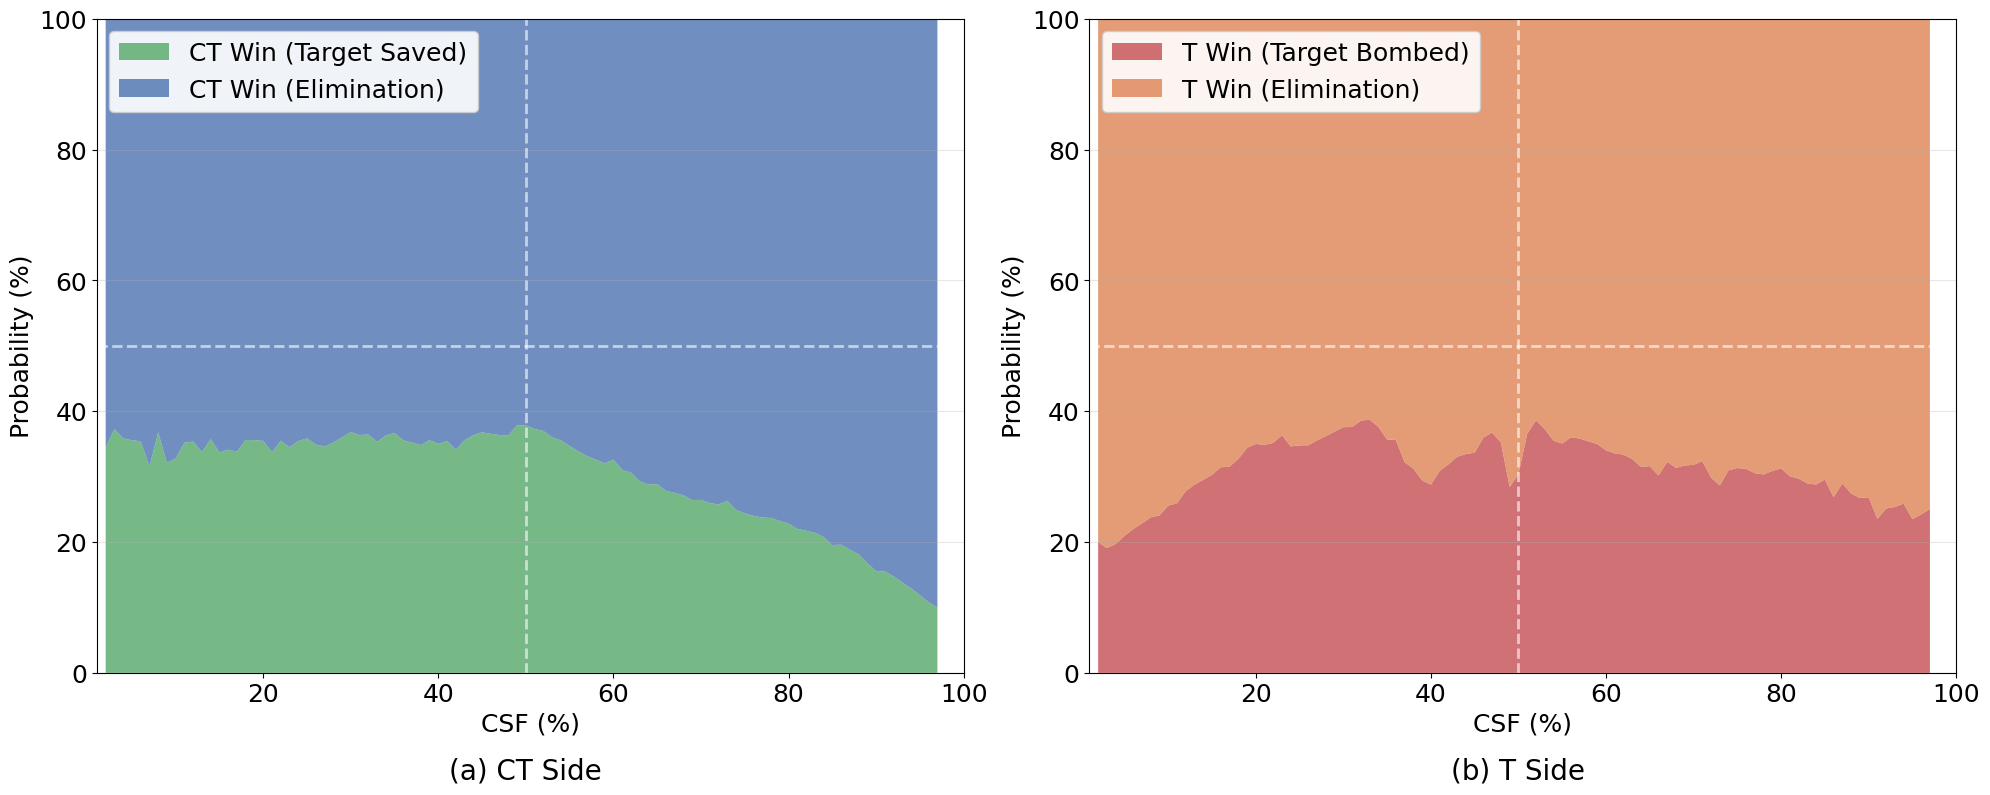

In [14]:
# Visualize round end reason distributions with stacked area plots (CT and T sides)
print("📊 Creating round end reason distribution visualization...")
print()

# Create visualization for CT and T sides
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

#fig.suptitle('Round End Reason Distribution by CSF Win Probability', 
#             fontsize=22, fontweight='bold')

# Use seaborn 'deep' palette colors
deep_palette = sns.color_palette('deep', n_colors=10)
colors = {
    1: deep_palette[3],  # Red - Target Bombed (T Win)
    2: deep_palette[1],  # Orange - Elimination (T Win)
    3: deep_palette[2],  # Green/Cyan - Defuse/Time (CT Win)
    4: deep_palette[0],  # Blue - Elimination (CT Win)
}

# Define which reasons are relevant for each side
side_relevant_reasons = {
    'CT': [3, 4],  # CT Win reasons only
    'T': [1, 2]    # T Win reasons only
}

for side_idx, side in enumerate(['CT', 'T']):
    ax = axes[side_idx]
    
    if side not in round_end_reason_analysis or not round_end_reason_analysis[side]:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
               transform=ax.transAxes, fontsize=22)
        ax.set_xlabel(f'{side} Side\nCSF Win Probability (%)', fontsize=22, fontweight='bold')
        ax.set_ylabel('Probability (%)', fontsize=20)
        continue
    
    side_data = round_end_reason_analysis[side]
    
    # Get relevant reasons for this side
    relevant_reasons = side_relevant_reasons[side]
    
    # Prepare data for stacked area plot
    csf_percentages = sorted(side_data.keys())
    reason_probs = {reason: [] for reason in relevant_reasons}
    
    for csf_pct in csf_percentages:
        data = side_data[csf_pct]
        reason_dist = data['reason_distribution']
        
        for reason in relevant_reasons:
            prob = reason_dist.get(reason, {}).get('probability', 0) * 100
            reason_probs[reason].append(prob)
    
    # Stack the areas
    y_data = np.array([reason_probs[reason] for reason in relevant_reasons])
    labels = [reason_names.get(reason, f"Reason {reason}") for reason in relevant_reasons]
    color_list = [colors.get(reason, 'gray') for reason in relevant_reasons]
    
    ax.stackplot(csf_percentages, y_data, 
                labels=labels,
                colors=color_list, alpha=0.8)
    
    if side == 'CT':
        label = "(a) CT Side"
    else:
        label = "(b) T Side"
    # Formatting
    ax.set_xlabel('CSF (%)', fontsize=18)
    ax.set_ylabel('Probability (%)', fontsize=18)
    ax.legend(loc='upper left', fontsize=18, framealpha=0.9)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xlim(1, 100)
    ax.set_ylim(0, 100)

    ax.text(0.5, -0.15, f'{label} ', 
            ha='center', va='center', transform=ax.transAxes, fontsize=20)
    
    # Add reference line at 50%
    ax.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=2)
    ax.axvline(x=50, color='white', linestyle='--', alpha=0.6, linewidth=2)

plt.tight_layout()
plt.show()


In [15]:
print("="*80)
print("📊 BOMB PLANTED ANALYSIS BY CSF PERCENTAGE (CT & T SIDES)")
print("="*80)
print("   (Reason 2: T Elimination wins only)")
print()

# Analyze bomb planted rates by CSF percentage for CT and T sides
# Only look at reason 2 (T Win Elimination - was 9)
bomb_planted_analysis = {}

for side in ['T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE BOMB PLANTED RATES")
    print(f"{'='*80}\n")
    
    side_analysis = {}
    
    for csf_pct in range(1, 101):  # 1% to 100% CSF (CT win probability)
        df_csf = detailed_df[detailed_df['csf_pct_bin'] == str(csf_pct)].copy()
        
        if len(df_csf) < 10:
            continue
        
        # Determine which rounds this side won AND filter by elimination reasons only
        if side == 'T':
            # T wins by elimination (reason 2 - was 9)
            df_side = df_csf[(df_csf['ct_winner'] == False) & 
                            (df_csf['round_end_reason'] == 2)].copy()
        
        if len(df_side) < 5:
            continue
        
        # Calculate bomb planted statistics
        total_rounds = len(df_side)
        bomb_planted_count = df_side['bomb_planted'].sum()
        bomb_planted_prob = bomb_planted_count / total_rounds if total_rounds > 0 else 0
        
        side_analysis[csf_pct] = {
            'n_rounds': total_rounds,
            'bomb_planted_count': int(bomb_planted_count),
            'bomb_planted_probability': float(bomb_planted_prob),
            'bomb_not_planted_probability': float(1 - bomb_planted_prob)
        }
    
    # Print sample at key CSF percentages
    print(f"{side} Bomb Planted Rate by CSF%:")
    print(f"{'CSF%':<6} {'N':<8} {'Planted':<12} {'Not Planted':<12}")
    print(f"{'-'*50}")
    
    for csf_pct in [10, 30, 50, 70, 90]:
        if csf_pct in side_analysis:
            data = side_analysis[csf_pct]
            print(f"{csf_pct:<6} {data['n_rounds']:<8,} "
                  f"{data['bomb_planted_probability']:<12.4f} "
                  f"{data['bomb_not_planted_probability']:<12.4f}")
    
    bomb_planted_analysis[side] = side_analysis

print()
print("="*80)
print("✅ Bomb planted analysis complete (Reason 2 only)")
print("="*80)
print()
print("💡 Use these distributions to sample bomb planted probability for T elimination wins")


📊 BOMB PLANTED ANALYSIS BY CSF PERCENTAGE (CT & T SIDES)
   (Reason 2: T Elimination wins only)


🔹 T SIDE BOMB PLANTED RATES

T Bomb Planted Rate by CSF%:
CSF%   N        Planted      Not Planted 
--------------------------------------------------
10     7,822    0.6478       0.3522      
30     6,558    0.7243       0.2757      
50     43,715   0.8436       0.1564      
70     2,097    0.8278       0.1722      
90     1,187    0.8391       0.1609      

✅ Bomb planted analysis complete (Reason 2 only)

💡 Use these distributions to sample bomb planted probability for T elimination wins


📊 Creating bomb planted distribution visualization...



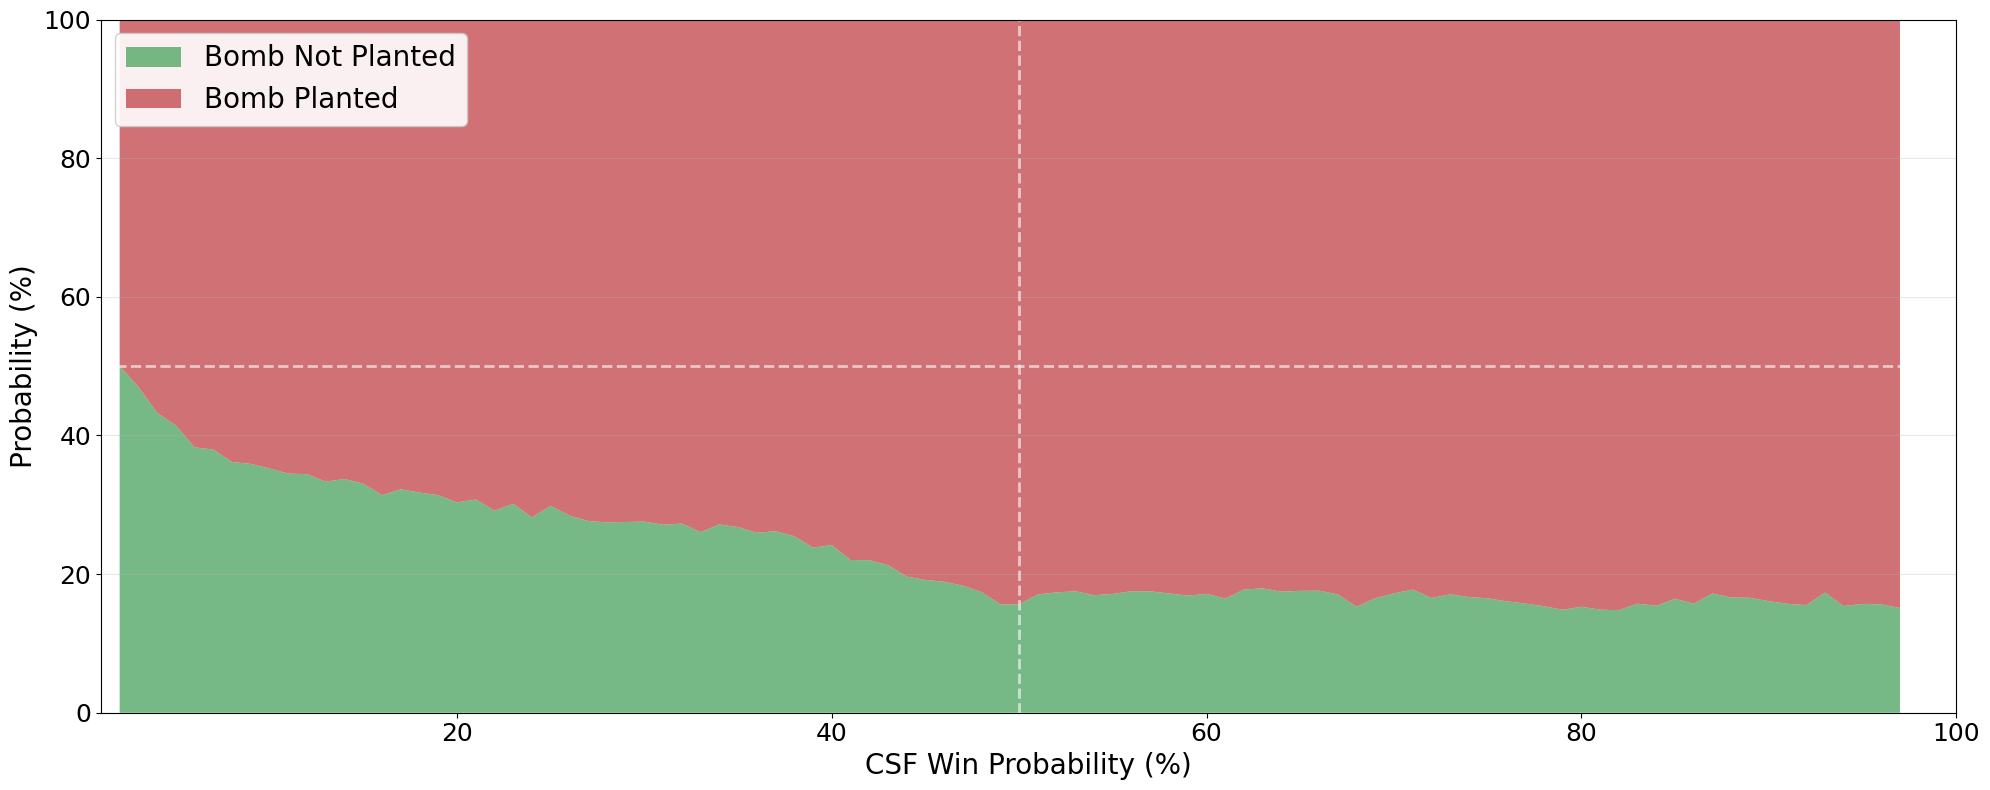

✅ Bomb planted visualization complete!

💡 KEY INSIGHTS:
   T SIDE (Reason 2 - T Win Elimination):
   • Shows bomb plant rate when T wins by elimination
   • Bomb planted means T planted then eliminated CT

   • Use these distributions in ABM for elimination round scenarios


In [16]:
# Visualize bomb planted distributions with stacked area plots (CT and T sides)
print("📊 Creating bomb planted distribution visualization...")
print()

# Create visualization for CT and T sides
fig, axes = plt.subplots(1, 1, figsize=(20, 8))


# Use seaborn 'deep' palette colors
deep_palette = sns.color_palette('deep', n_colors=10)
colors_bomb = {
    'planted': deep_palette[3],      # Red - Bomb Planted
    'not_planted': deep_palette[2],  # Green - Bomb Not Planted
}

for side_idx, side in enumerate(['T']):
    
    
    if side not in bomb_planted_analysis or not bomb_planted_analysis[side]:
        axes.text(0.5, 0.5, 'No Data', ha='center', va='center', 
               transform=axes.transAxes, fontsize=14)
        axes.set_xlabel('CSF Win Probability (%)', fontsize=12)
        axes.set_ylabel('Probability (%)', fontsize=12)
        axes.set_title(f'{side} Side', fontsize=13, fontweight='bold')
        continue
    
    side_data = bomb_planted_analysis[side]
    
    # Prepare data for stacked area plot
    csf_percentages = sorted(side_data.keys())
    planted_probs = []
    not_planted_probs = []
    
    for csf_pct in csf_percentages:
        data = side_data[csf_pct]
        planted_probs.append(data['bomb_planted_probability'] * 100)
        not_planted_probs.append(data['bomb_not_planted_probability'] * 100)
    
    # Stack the areas
    y_data = np.array([not_planted_probs, planted_probs])
    labels = ['Bomb Not Planted', 'Bomb Planted']
    color_list = [colors_bomb['not_planted'], colors_bomb['planted']]
    
    axes.stackplot(csf_percentages, y_data, 
                labels=labels,
                colors=color_list, alpha=0.8)
    
    # Formatting
    axes.set_xlabel('CSF Win Probability (%)', fontsize=20)
    axes.set_ylabel('Probability (%)', fontsize=20)
    axes.legend(loc='upper left', fontsize=20, framealpha=0.9)
    axes.tick_params(axis='both', which='major', labelsize=18)
    axes.grid(True, alpha=0.3, axis='y')
    axes.set_xlim(1, 100)
    axes.set_ylim(0, 100)
    
    # Add reference line at 50%
    axes.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=2)
    axes.axvline(x=50, color='white', linestyle='--', alpha=0.6, linewidth=2)

plt.tight_layout()
plt.show()

print("✅ Bomb planted visualization complete!")
print()
print("💡 KEY INSIGHTS:")
print("   T SIDE (Reason 2 - T Win Elimination):")
print("   • Shows bomb plant rate when T wins by elimination")
print("   • Bomb planted means T planted then eliminated CT")
print()
print("   • Use these distributions in ABM for elimination round scenarios")


# Survivor Prediction Model

We'll analyze the relationship between:
1. **CSF prediction** (win probability based on equipment advantage)
2. **Round end reason** (how the round ended)
3. **Number of survivors** (outcome)

This will help the ABM predict realistic survivor counts based on equipment advantage and round outcome.

In [17]:
print("="*80)
print("📊 SURVIVOR CUMULATIVE DISTRIBUTION BY CSF PERCENTAGE")
print("="*80)
print()

# Get top 4 round end reasons (based on frequency)
top_reasons = detailed_df['round_end_reason'].value_counts().head(4).index.tolist()
reason_names = {
    1: "T Win (Target Bombed)",
    2: "T Win (Elimination)",
    3: "CT Win (Defuse)",
    4: "CT Win (Elimination)",
}

print("Top 4 Round End Reasons:")
for reason in top_reasons:
    reason_name = reason_names.get(reason, f"Reason {reason}")
    count = (detailed_df['round_end_reason'] == reason).sum()
    pct = count / len(detailed_df) * 100
    print(f"   {reason}: {reason_name} - {count:,} rounds ({pct:.2f}%)")
print()

# Analyze survivor distributions for each round end reason and CSF percentage
survivor_analysis = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE SURVIVOR DISTRIBUTIONS (All Reasons)")
    print(f"{'='*80}\n")

    survivor_analysis[side] = {}

    # Process each of the top 4 round end reasons
    for reason in top_reasons:
        reason_name = reason_names.get(reason, f"Reason {reason}")
        print(f"\n   {'─'*70}")
        print(f"   🎯 {reason_name} (Reason {reason})")
        print(f"   {'─'*70}")

        survivor_analysis[side][reason] = {
            'reason_name': reason_name,
            'csf_distributions': {}
        }

        # Analyze for each CSF percentage bin
        for csf_pct in range(1, 101):  # 1% to 100%
            # Filter for this CSF percentage
            df_csf = detailed_df[detailed_df['csf_pct_bin'] == str(csf_pct)].copy()
            if len(df_csf) < 10:
                continue

            # Filter for this round end reason
            df_reason = df_csf[df_csf['round_end_reason'] == reason].copy()
            if len(df_reason) < 5:
                continue

            # Always include survivor counts for both sides (not only winners)
            if side == 'CT':
                survivors = df_reason['ct_survivors']
            else:
                survivors = df_reason['t_survivors']

            # Calculate survivor statistics
            surv_counts = survivors.value_counts()
            total_rounds = len(survivors)

            surv_probs = {}
            for n_survivors in range(0, 6):  # 0 to 5 survivors
                surv_count = surv_counts.get(n_survivors, 0)
                surv_prob = surv_count / total_rounds if total_rounds > 0 else 0
                surv_probs[n_survivors] = {
                    'count': int(surv_count),
                    'probability': float(surv_prob)
                }

            # Cumulative distribution (simple floats)
            cumulative_prob = 0.0
            cumulative_dist = {}
            for n_survivors in range(0, 6):
                cumulative_prob += surv_probs[n_survivors]['probability']
                cumulative_dist[n_survivors] = float(cumulative_prob)

            # Mean survivors
            mean_survivors = sum(n * surv_probs[n]['probability'] for n in range(6))

            survivor_analysis[side][reason]['csf_distributions'][csf_pct] = {
                'n_rounds': total_rounds,
                'survivor_probabilities': surv_probs,
                'cumulative_distribution': cumulative_dist,
                'mean_survivors': float(mean_survivors)
            }

        # Sample distributions at key CSF percentages
        print(f"\n   {side} Survivor Distribution at Key CSF Percentages:")
        print(f"   {'CSF%':<6} {'N':<8} {'0 Surv':<10} {'1 Surv':<10} {'2 Surv':<10} {'3 Surv':<10} {'4 Surv':<10} {'5 Surv':<10}")
        print(f"   {'-'*80}")
        for csf_pct in [10, 30, 50, 70, 90]:
            if csf_pct in survivor_analysis[side][reason]['csf_distributions']:
                dist_data = survivor_analysis[side][reason]['csf_distributions'][csf_pct]
                surv_data = dist_data['survivor_probabilities']
                print(
                    f"   {csf_pct:<6} {dist_data['n_rounds']:<8,} "
                    f"{surv_data.get(0, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(1, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(2, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(3, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(4, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(5, {}).get('probability', 0):<10.4f}"
                )

print("\n" + "="*80)
print("✅ Survivor distribution analysis complete")
print("="*80)
print()
print("💡 Use cumulative_distribution for efficient inverse transform sampling in ABM")

📊 SURVIVOR CUMULATIVE DISTRIBUTION BY CSF PERCENTAGE

Top 4 Round End Reasons:
   4: CT Win (Elimination) - 923,305 rounds (35.88%)
   2: T Win (Elimination) - 841,615 rounds (32.71%)
   1: T Win (Target Bombed) - 404,616 rounds (15.73%)
   3: CT Win (Defuse) - 403,435 rounds (15.68%)


🔹 CT SIDE SURVIVOR DISTRIBUTIONS (All Reasons)


   ──────────────────────────────────────────────────────────────────────
   🎯 CT Win (Elimination) (Reason 4)
   ──────────────────────────────────────────────────────────────────────

   CT Survivor Distribution at Key CSF Percentages:
   CSF%   N        0 Surv     1 Surv     2 Surv     3 Surv     4 Surv     5 Surv    
   --------------------------------------------------------------------------------
   10     891      0.0011     0.1695     0.3300     0.2974     0.1684     0.0337    
   30     2,609    0.0015     0.1269     0.2817     0.3039     0.2208     0.0652    
   50     40,217   0.0002     0.0695     0.2027     0.3201     0.2853     0.1222    
 

📊 Creating stacked survivor distribution visualizations...


Visualizing survivor distribution for CT Win (Elimination) (Reason 4)...


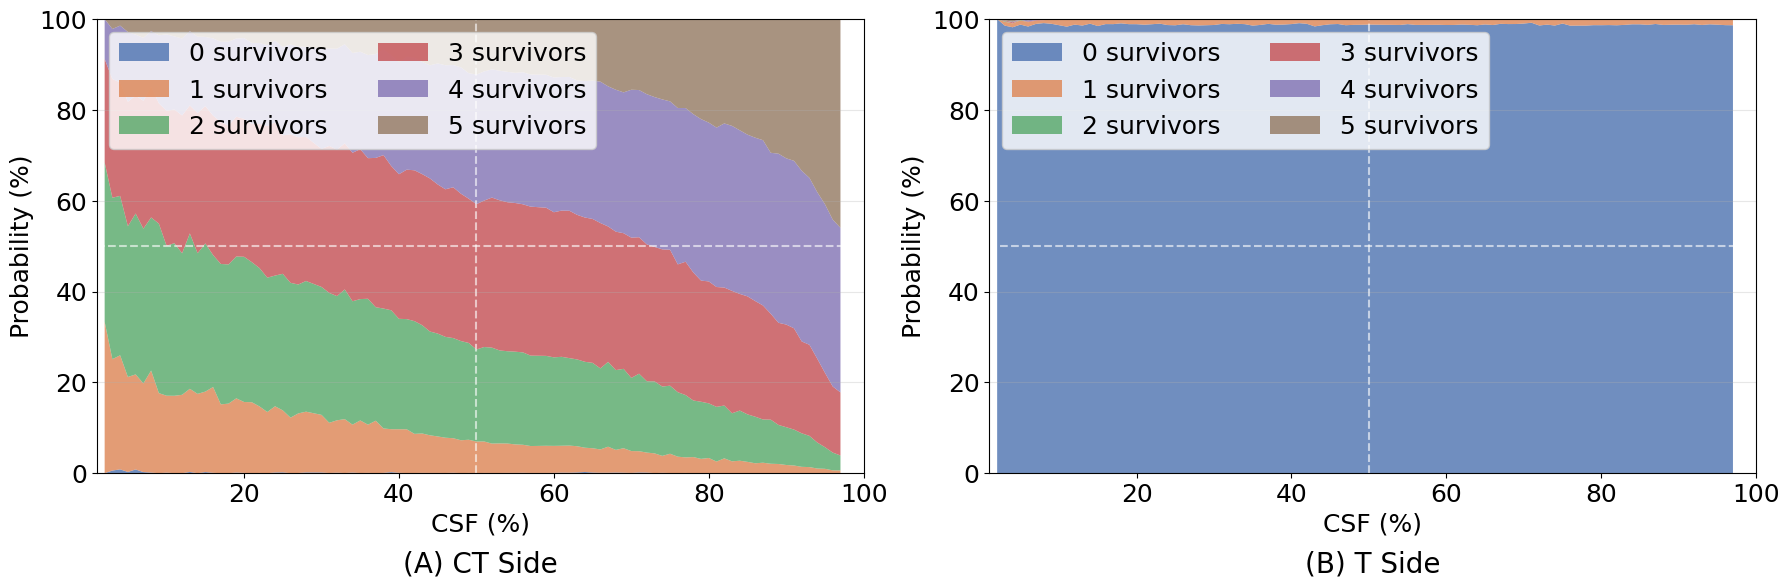


Visualizing survivor distribution for T Win (Elimination) (Reason 2)...


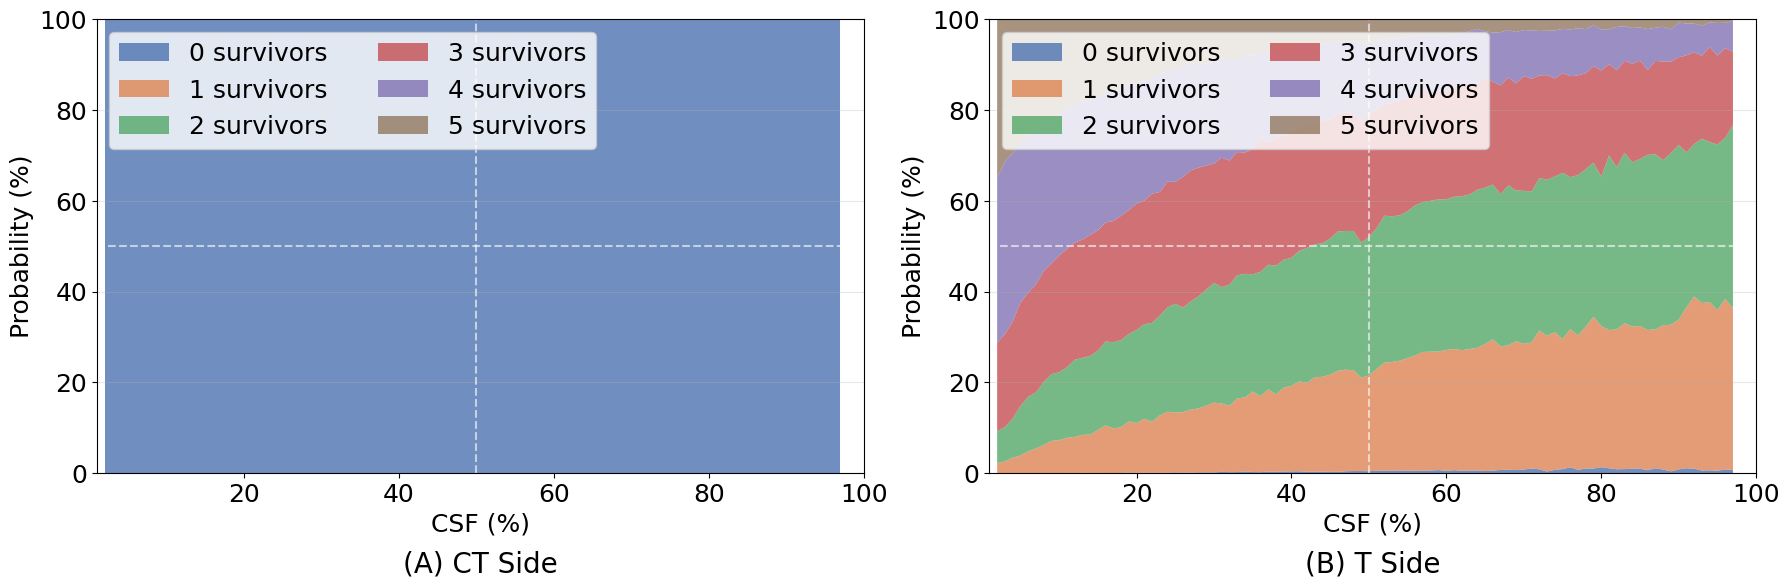


Visualizing survivor distribution for T Win (Target Bombed) (Reason 1)...


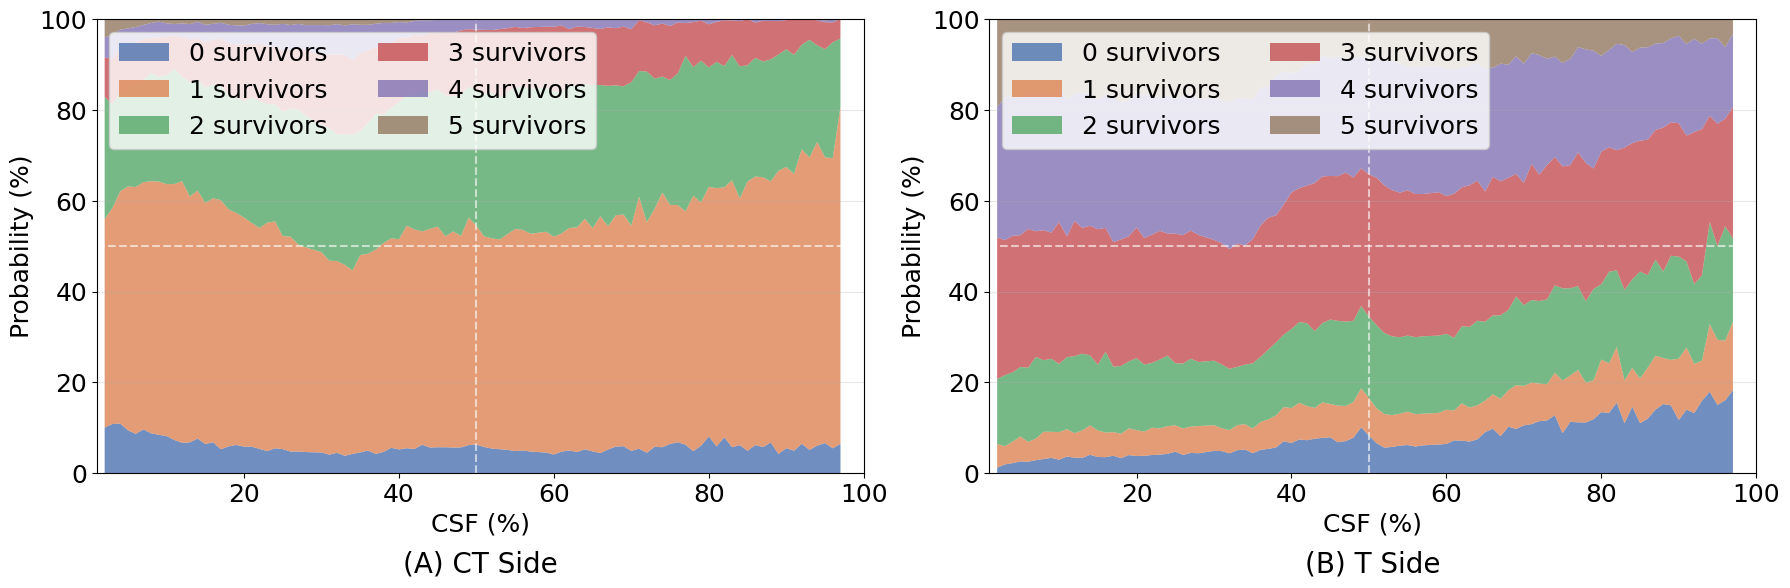


Visualizing survivor distribution for CT Win (Defuse) (Reason 3)...


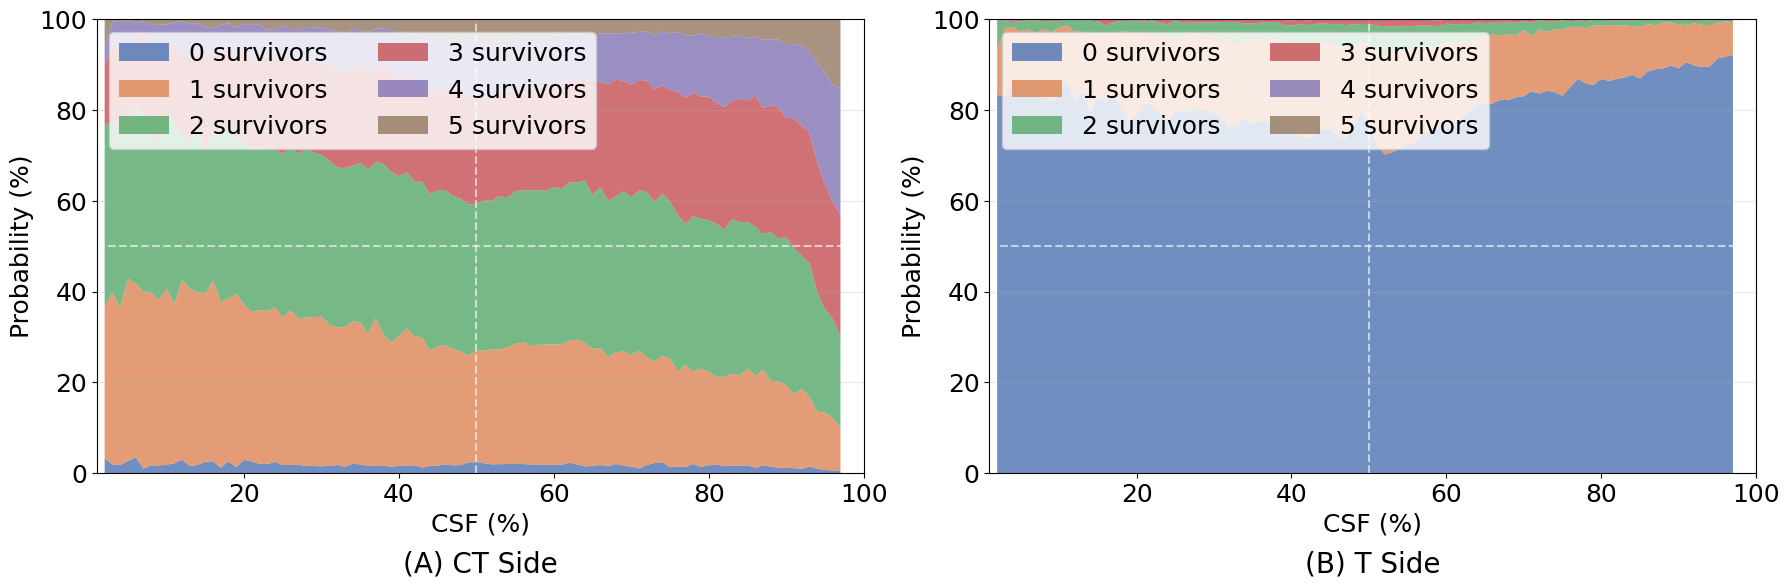

✅ Stacked distribution visualizations complete!



In [18]:
# Visualize survivor distributions with stacked area plots
print("📊 Creating stacked survivor distribution visualizations...")
print()

# Create visualizations for each round end reason
for reason in top_reasons:
    reason_name = reason_names.get(reason, f"Reason {reason}")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    # fig.suptitle(f'{reason_name} (Reason {reason}) - Survivor Distribution by CSF%', fontsize=16, fontweight='bold')
    
    print(f"\nVisualizing survivor distribution for {reason_name} (Reason {reason})...")

    # Plot for each side
    for side_idx, side in enumerate(['CT', 'T']):
        ax = axes[side_idx]
        
        if side in survivor_analysis and reason in survivor_analysis[side]:
            reason_data = survivor_analysis[side][reason]
            csf_data = reason_data.get('csf_distributions', {})
            
            if not csf_data:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=14)
                ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
                ax.set_ylabel('Probability (%)', fontsize=11)
                ax.set_title(f'{side} Side', fontsize=12, fontweight='bold')
                continue
            
            # Prepare data: for each survivor count (0-5), track probability across CSF percentages
            csf_percentages = sorted(csf_data.keys())
            survivor_probs = {i: [] for i in range(6)}
            
            for csf_pct in csf_percentages:
                dist_data = csf_data[csf_pct]
                surv_prob_data = dist_data['survivor_probabilities']
                
                # Get individual probabilities directly
                for surv_count in range(6):
                    prob = surv_prob_data.get(surv_count, {}).get('probability', 0)
                    survivor_probs[surv_count].append(prob * 100)
            
            # Create stacked area plot using seaborn 'deep' palette
            colors = sns.color_palette('deep', n_colors=6)
            
            # Stack the areas (convert to numpy arrays for stacking)
            y_data = np.array([survivor_probs[i] for i in range(6)])
            
            # Plot stacked areas
            ax.stackplot(csf_percentages, y_data, 
                        labels=[f'{i} survivors' for i in range(6)],
                        colors=colors, alpha=0.8)
            
            # Label for double plot
            if side == 'CT':
                label = "(A) CT Side"
            else:
                label = "(B) T Side"

            # Formatting
            ax.set_xlabel(f'CSF (%)', fontsize=18)
            ax.set_ylabel('Probability (%)', fontsize=18)
            #ax.set_title(f'{side} Side', fontsize=20, fontweight='bold')
            ax.legend(loc='upper left', fontsize=18, ncol=2, bbox_to_anchor=(0, 1))
            ax.tick_params(axis='both', which='major', labelsize=18)
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_xlim(1, 100)
            ax.set_ylim(0, 100)

            ax.text(0.5, -0.20, f'{label}', 
                    ha='center', va='center', transform=ax.transAxes, fontsize=20)
            
            # Add reference lines at 50%
            ax.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=1.5)
            ax.axvline(x=50, color='white', linestyle='--', alpha=0.6, linewidth=1.5)
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_xlabel('CSF (%)', fontsize=18)
            ax.set_ylabel('Probability (%)', fontsize=18)
            #ax.set_title(f'{side} Side', fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("✅ Stacked distribution visualizations complete!")
print()


📊 Creating survivor CDF visualizations...



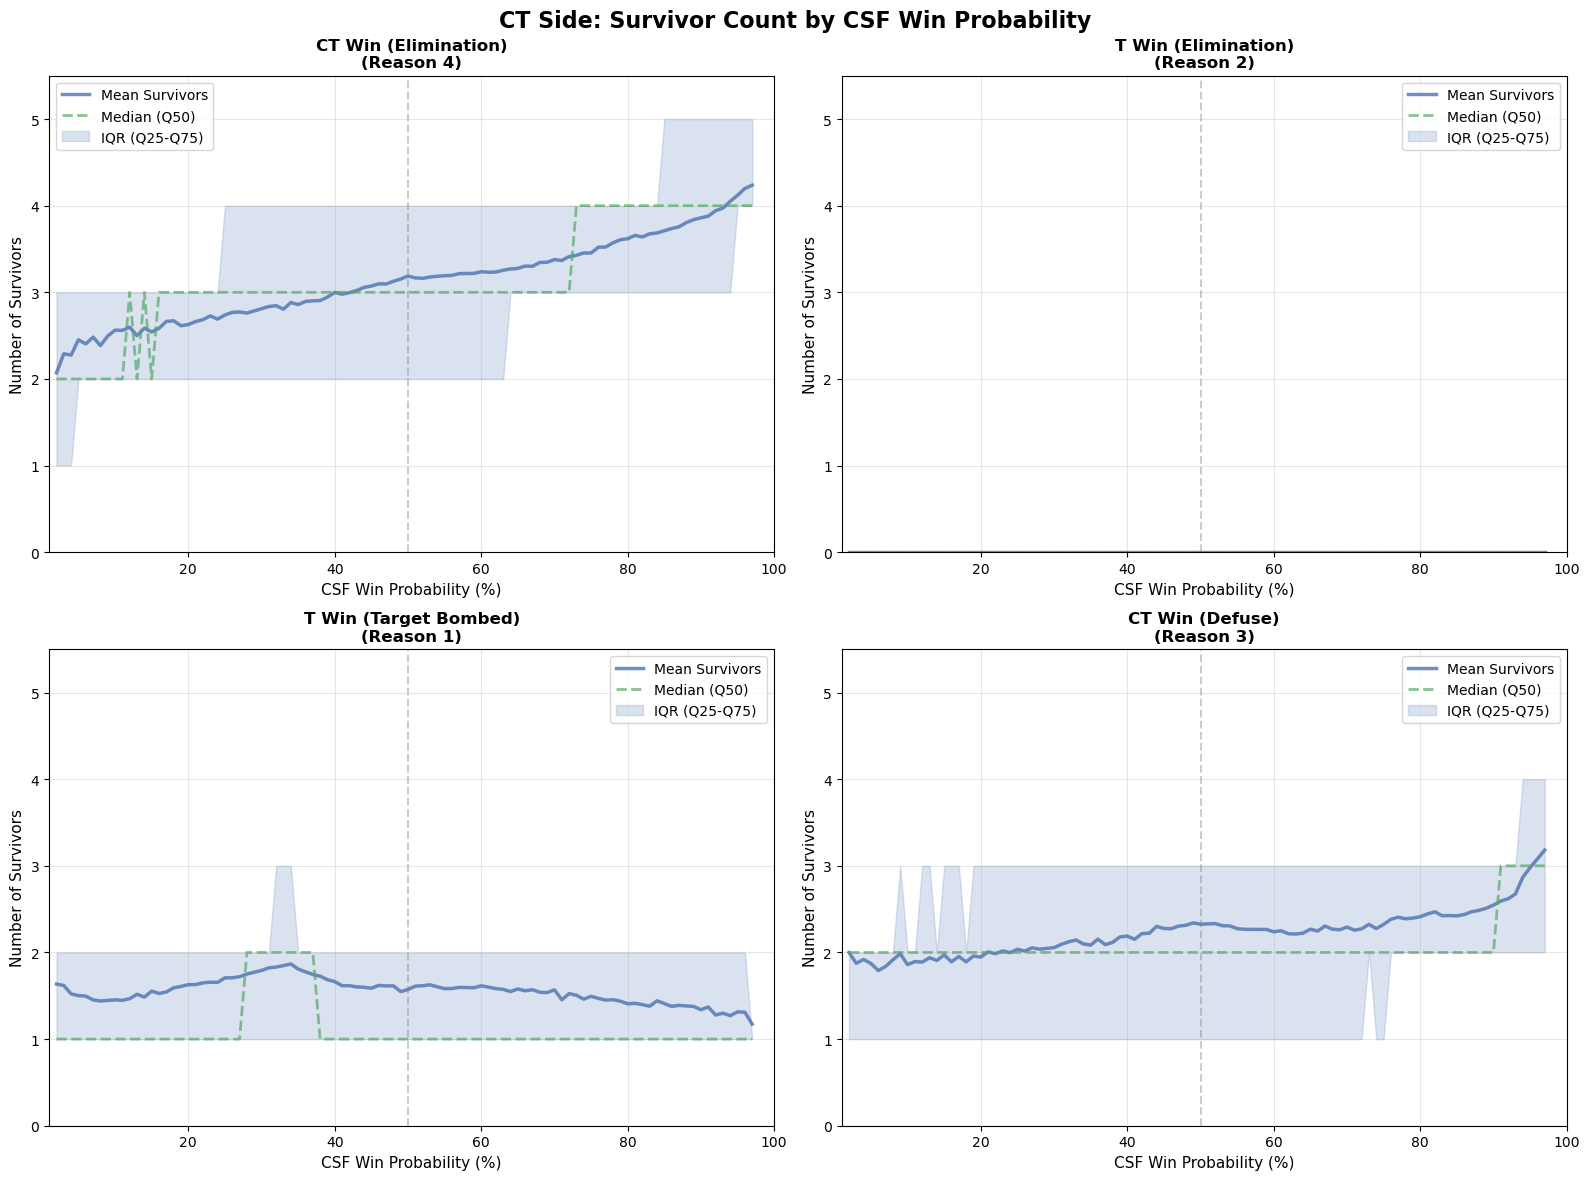

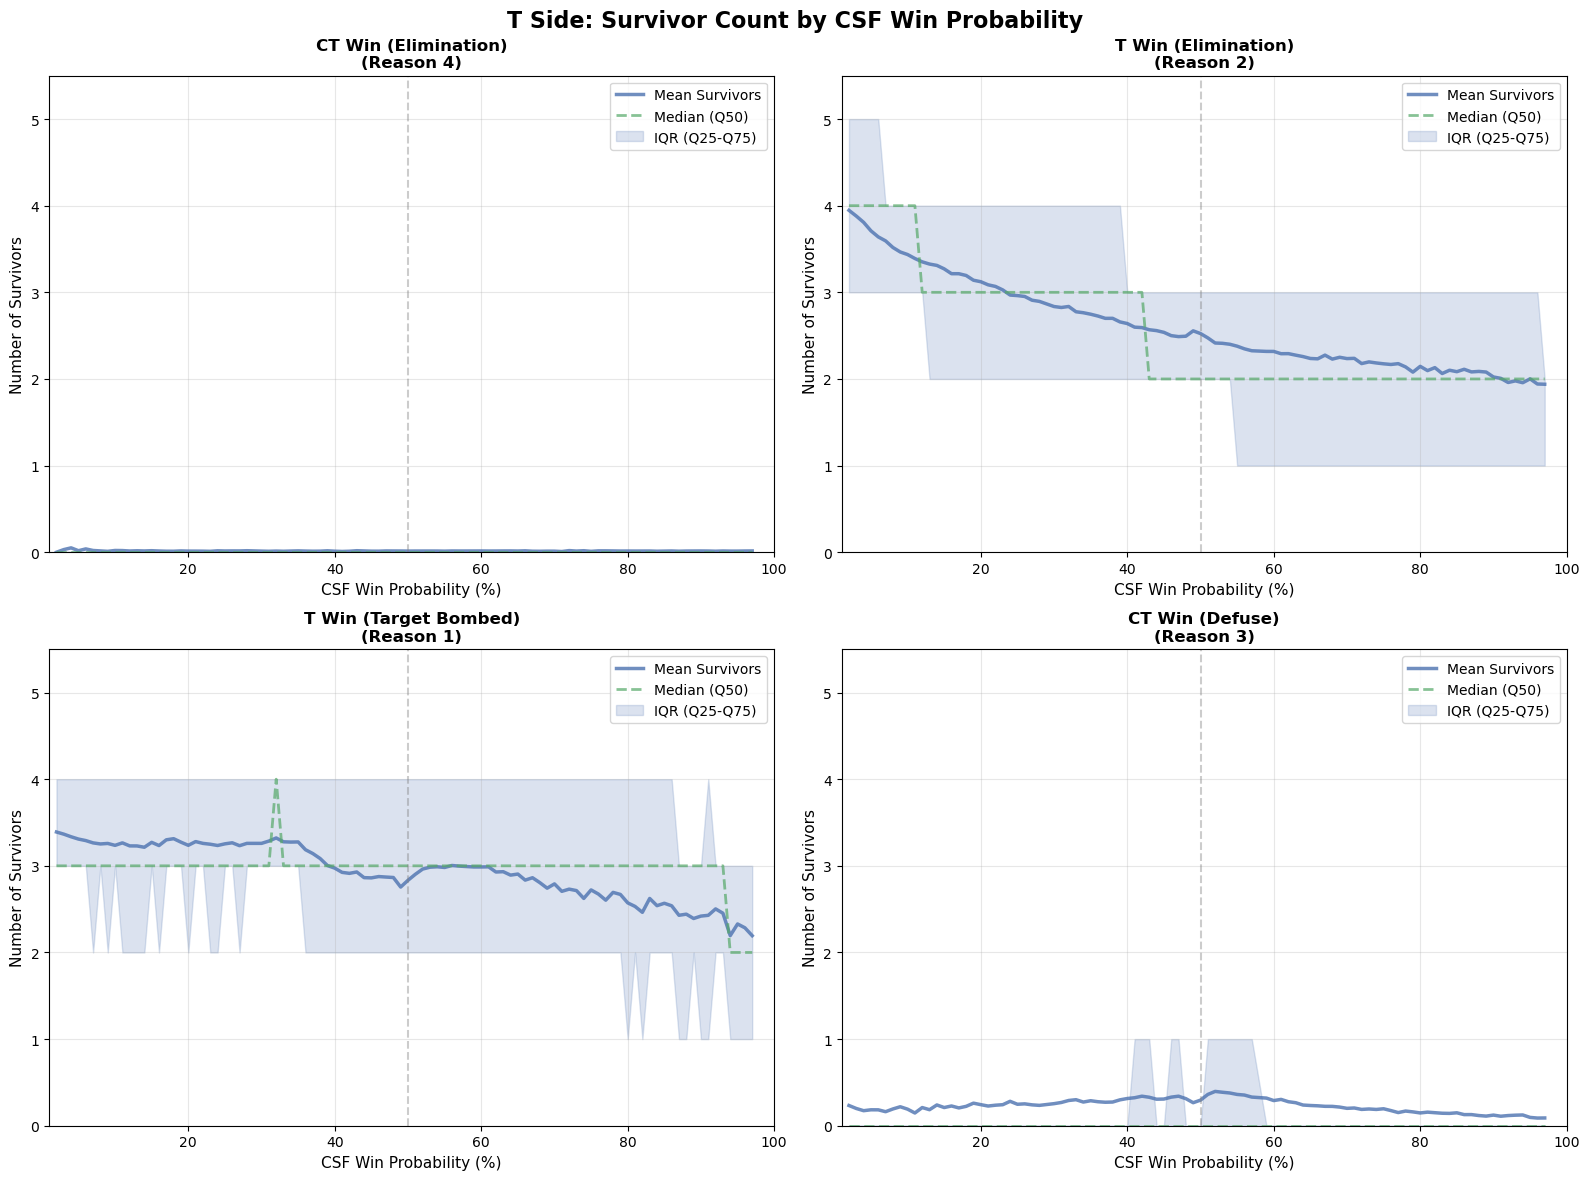

✅ Visualizations complete!

💡 KEY INSIGHTS:
   • CSF advantage affects survivor distribution
   • Different round end reasons show different patterns
   • Use these distributions in ABM to sample realistic survivor counts


In [19]:
# Visualize survivor cumulative distributions by CSF percentage
print("📊 Creating survivor CDF visualizations...")
print()

for side in ['CT', 'T']:
    side_data = survivor_analysis[side]
    n_reasons = len(side_data)
    
    if n_reasons == 0:
        continue
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle(f'{side} Side: Survivor Count by CSF Win Probability', fontsize=16, fontweight='bold')
    
    for idx, (reason, reason_info) in enumerate(side_data.items()):
        if idx >= 4:
            break
        
        ax = axes[idx]
        reason_name = reason_info['reason_name']
        csf_data = reason_info['csf_distributions']
        
        # Extract data for plotting
        csf_percentages = sorted(csf_data.keys())
        mean_survivors = [csf_data[csf]['mean_survivors'] for csf in csf_percentages]
        
        # Use seaborn 'deep' palette colors
        deep_palette = sns.color_palette('deep', n_colors=10)
        
        # Plot mean survivors
        ax.plot(csf_percentages, mean_survivors, color=deep_palette[0], linewidth=2.5, label='Mean Survivors', alpha=0.8)
        
        # Plot quantiles (25th, 50th, 75th percentiles derived from CDF)
        q25_survivors = []
        q50_survivors = []
        q75_survivors = []
        
        for csf in csf_percentages:
            cdf = csf_data[csf]['cumulative_distribution']
            
            # Find survivor counts at quantiles
            q25_surv = next((s for s in range(6) if cdf[s] >= 0.25), 5)
            q50_surv = next((s for s in range(6) if cdf[s] >= 0.50), 5)
            q75_surv = next((s for s in range(6) if cdf[s] >= 0.75), 5)
            
            q25_survivors.append(q25_surv)
            q50_survivors.append(q50_surv)
            q75_survivors.append(q75_surv)
        
        ax.plot(csf_percentages, q50_survivors, '--', color=deep_palette[2], linewidth=2, label='Median (Q50)', alpha=0.7)
        ax.fill_between(csf_percentages, q25_survivors, q75_survivors, alpha=0.2, color=deep_palette[0], label='IQR (Q25-Q75)')
        
        ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
        ax.set_ylabel('Number of Survivors', fontsize=11)
        ax.set_title(f"{reason_name}\n(Reason {reason})", fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(1, 100)
        ax.set_ylim(0, 5.5)
        ax.set_yticks(range(0, 6))
        # Add vertical line at 50%
        ax.axvline(x=50, color='gray', linestyle='--', alpha=0.4, linewidth=1.5)
    
    # Hide unused subplots
    for idx in range(len(side_data), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("✅ Visualizations complete!")
print()
print("💡 KEY INSIGHTS:")
print("   • CSF advantage affects survivor distribution")

print("   • Different round end reasons show different patterns")
print("   • Use these distributions in ABM to sample realistic survivor counts")

# Equipment Saved Per Survivor Analysis

Prepare data for quantile regression grouped by round end reason.

In [20]:
print("="*80)
print("📊 PREPARE EQUIPMENT SAVED DATA FOR QUANTILE REGRESSION")
print("="*80)
print()

# Prepare data for both CT and T sides with improved target variable
improved_regression_results = []

for side in ['CT', 'T']:
    print(f"🔹 Processing {side} side data...")
    
    # Select relevant columns
    if side == 'CT':
        df_side = detailed_df[['round_end_reason', 'ct_survivors', 'ct_equipment', 't_equipment', 'ct_saved_equipment']].copy()
        df_side.columns = ['round_end_reason', 'survivors', 'ct_equipment', 't_equipment', 'saved_equipment']
        df_side['is_ct'] = 1
    else:
        df_side = detailed_df[['round_end_reason', 't_survivors', 'ct_equipment', 't_equipment', 't_saved_equipment']].copy()
        df_side.columns = ['round_end_reason', 'survivors', 'ct_equipment', 't_equipment', 'saved_equipment']
        df_side['is_ct'] = 0
    
    # Remove rows with missing values, exclude rounds where no equipment was saved, or zero survivors
    df_side = df_side.dropna()
    df_side = df_side[(df_side['saved_equipment'] > 0) & (df_side['survivors'] > 0)].copy()
    
    # Calculate total equipment in the round
    df_side['total_equipment'] = df_side['ct_equipment'] + df_side['t_equipment']
    
    # Calculate equipment saved per survivor as % of total equipment
    df_side['saved_per_survivor_pct'] = (df_side['saved_equipment'] / df_side['survivors']) / df_side['total_equipment'] * 100
    
    # Remove false Data where saved equipment is more than total available (over 100%)
    df_side = df_side[df_side['saved_per_survivor_pct'] <= 100].copy()
    
    print(f"   Dataset: {len(df_side):,} rounds")
    print(f"   Mean: {df_side['saved_per_survivor_pct'].mean():.2f}% of total equipment saved per survivor")
    print()
    
    # Store results
    improved_regression_results.append({
        'side': side,
        'df_side': df_side
    })

print("✅ Data preparation complete")
print()

📊 PREPARE EQUIPMENT SAVED DATA FOR QUANTILE REGRESSION

🔹 Processing CT side data...
   Dataset: 1,523,446 rounds
   Mean: 11.78% of total equipment saved per survivor

🔹 Processing T side data...
   Dataset: 1,153,693 rounds
   Mean: 11.91% of total equipment saved per survivor

✅ Data preparation complete



In [21]:
print("="*80)
print("📊 EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION (ECDF) ANALYSIS")
print("📊 Equipment Saved Per Survivor (% of Total Equipment)")
print("="*80)
print()

# Store ECDF results for JSON export
equipment_distributions = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE - EQUIPMENT SAVED DISTRIBUTIONS")
    print(f"{'='*80}\n")
    
    equipment_distributions[side] = {}
    
    # Get data from improved regression
    df_side = improved_regression_results[0 if side == 'CT' else 1]['df_side'].copy()
    
    # Process each of the top 4 round end reasons
    for reason in top_reasons:
        reason_name = reason_names.get(reason, f"Reason {reason}")
        print(f"\n   {'─'*70}")
        print(f"   🎯 {reason_name} (Reason {reason})")
        print(f"   {'─'*70}")
        
        # Filter data for this round end reason
        df_reason = df_side[df_side['round_end_reason'] == reason].copy()
        
        if len(df_reason) < 50:  # Skip if insufficient data
            print(f"   ⚠️  Insufficient data ({len(df_reason)} rounds) - skipping")
            continue
        
        equipment_distributions[side][reason] = {
            'reason_name': reason_name,
            'survivor_distributions': {}
        }
        
        # Analyze for each survivor count (1-5)
        for surv in range(1, 6):
            df_surv = df_reason[df_reason['survivors'] == surv].copy()
            
            if len(df_surv) < 10:
                continue
            
            # Get equipment saved percentages
            eq_saved_pct = df_surv['saved_per_survivor_pct'].values
            
            # Calculate ECDF (Empirical Cumulative Distribution Function)
            sorted_data = np.sort(eq_saved_pct)
            ecdf_x = sorted_data
            ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            # Calculate statistics
            stats_dict = {
                'n_samples': len(eq_saved_pct),
                'mean': float(eq_saved_pct.mean()),
                'median': float(np.median(eq_saved_pct)),
                'std': float(eq_saved_pct.std()),
                'min': float(eq_saved_pct.min()),
                'max': float(eq_saved_pct.max()),
                'q25': float(np.percentile(eq_saved_pct, 25)),
                'q75': float(np.percentile(eq_saved_pct, 75)),
                # Store ECDF for export (sample to ~200 points for accuracy)
                'ecdf': {
                    'x': [float(x) for x in ecdf_x[::max(1, len(ecdf_x)//200)].tolist()],
                    'y': [float(y) for y in ecdf_y[::max(1, len(ecdf_y)//200)].tolist()]
                }
            }
            
            equipment_distributions[side][reason]['survivor_distributions'][surv] = stats_dict
            
            # Print summary
            print(f"\n   {surv} Survivor{'s' if surv > 1 else ''} (n={len(eq_saved_pct):,}):")
            print(f"      Mean: {stats_dict['mean']:.2f}%  |  Median: {stats_dict['median']:.2f}%  |  Std: {stats_dict['std']:.2f}%")
            print(f"      Range: [{stats_dict['min']:.2f}%, {stats_dict['max']:.2f}%]  |  IQR: [{stats_dict['q25']:.2f}%, {stats_dict['q75']:.2f}%]")
            print(f"      ECDF Points: {len(stats_dict['ecdf']['x'])}")

print("\n" + "="*80)
print("✅ ECDF ANALYSIS COMPLETE")
print("="*80)
print()
print("💡 Distributions stored for JSON export")
print("   • ECDF: Empirical Cumulative Distribution Function")
print("   • Use inverse transform sampling in ABM for stochastic equipment values")


📊 EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION (ECDF) ANALYSIS
📊 Equipment Saved Per Survivor (% of Total Equipment)


🔹 CT SIDE - EQUIPMENT SAVED DISTRIBUTIONS


   ──────────────────────────────────────────────────────────────────────
   🎯 CT Win (Elimination) (Reason 4)
   ──────────────────────────────────────────────────────────────────────

   1 Survivor (n=44,293):
      Mean: 12.72%  |  Median: 12.17%  |  Std: 3.57%
      Range: [0.82%, 55.62%]  |  IQR: [10.30%, 14.40%]
      ECDF Points: 201

   2 Survivors (n=140,027):
      Mean: 11.83%  |  Median: 11.10%  |  Std: 3.30%
      Range: [0.91%, 46.02%]  |  IQR: [9.80%, 13.32%]
      ECDF Points: 201

   3 Survivors (n=237,222):
      Mean: 11.87%  |  Median: 10.83%  |  Std: 3.65%
      Range: [0.63%, 78.06%]  |  IQR: [9.65%, 14.06%]
      ECDF Points: 201

   4 Survivors (n=249,889):
      Mean: 12.56%  |  Median: 11.31%  |  Std: 4.10%
      Range: [0.42%, 47.00%]  |  IQR: [9.69%, 16.02%]
      ECDF Points: 201

   5 Survivors (n=

📊 Creating ECDF visualizations...


Visualizing ECDF for CT side - CT Win (Elimination) (Reason 4)...


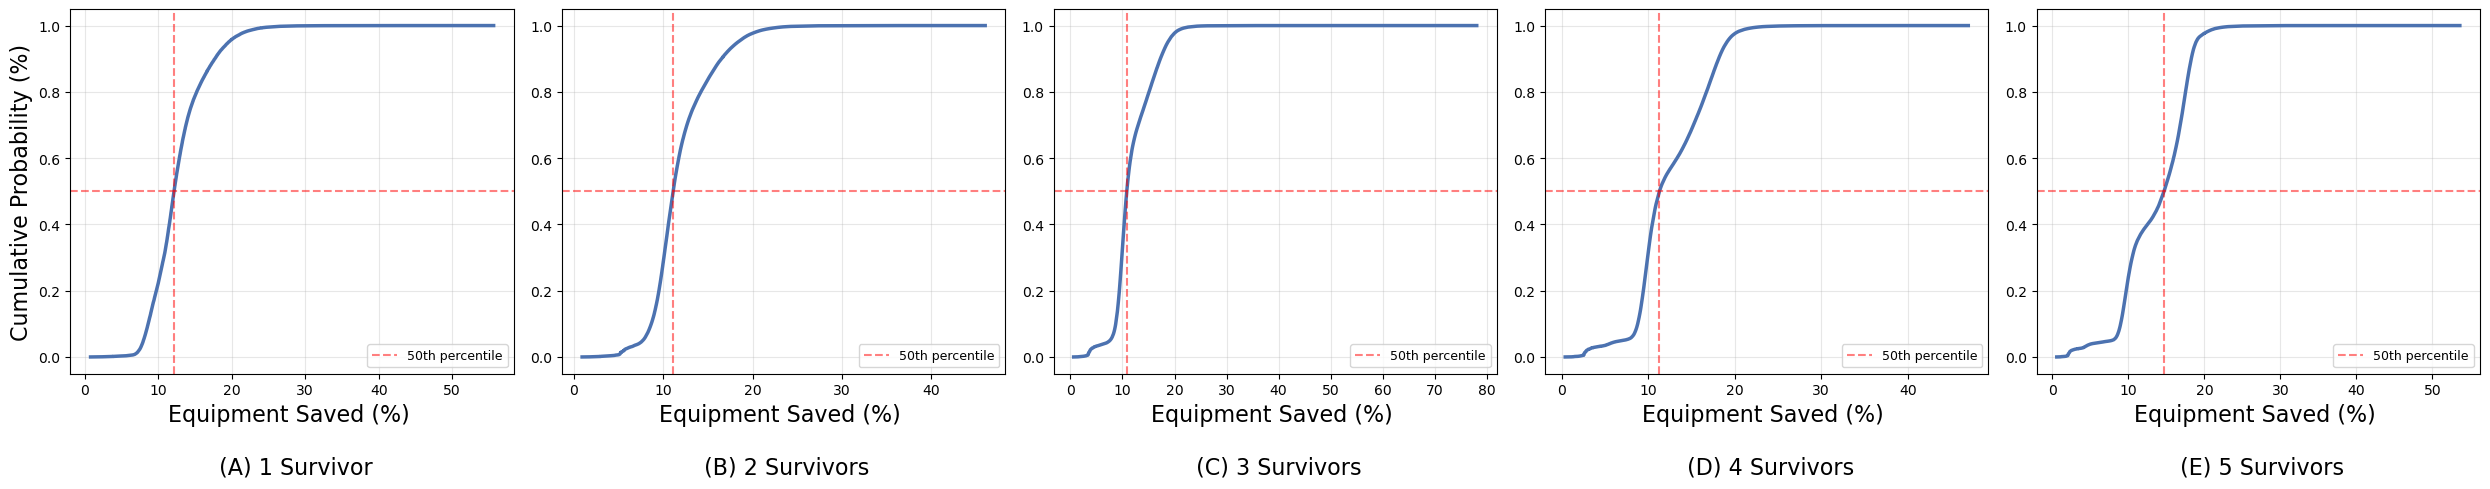


Visualizing ECDF for CT side - T Win (Target Bombed) (Reason 1)...


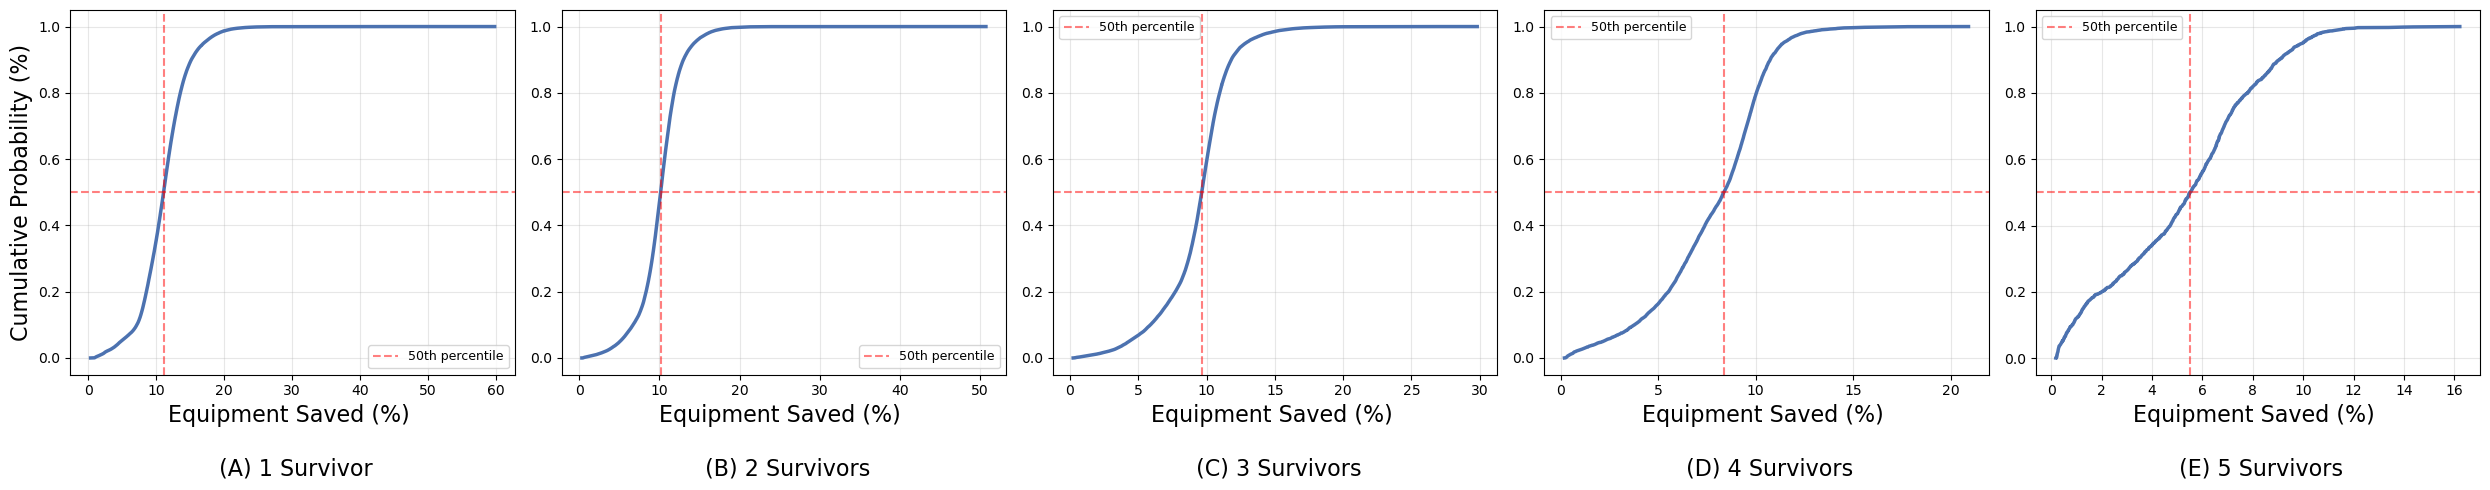


Visualizing ECDF for CT side - CT Win (Defuse) (Reason 3)...


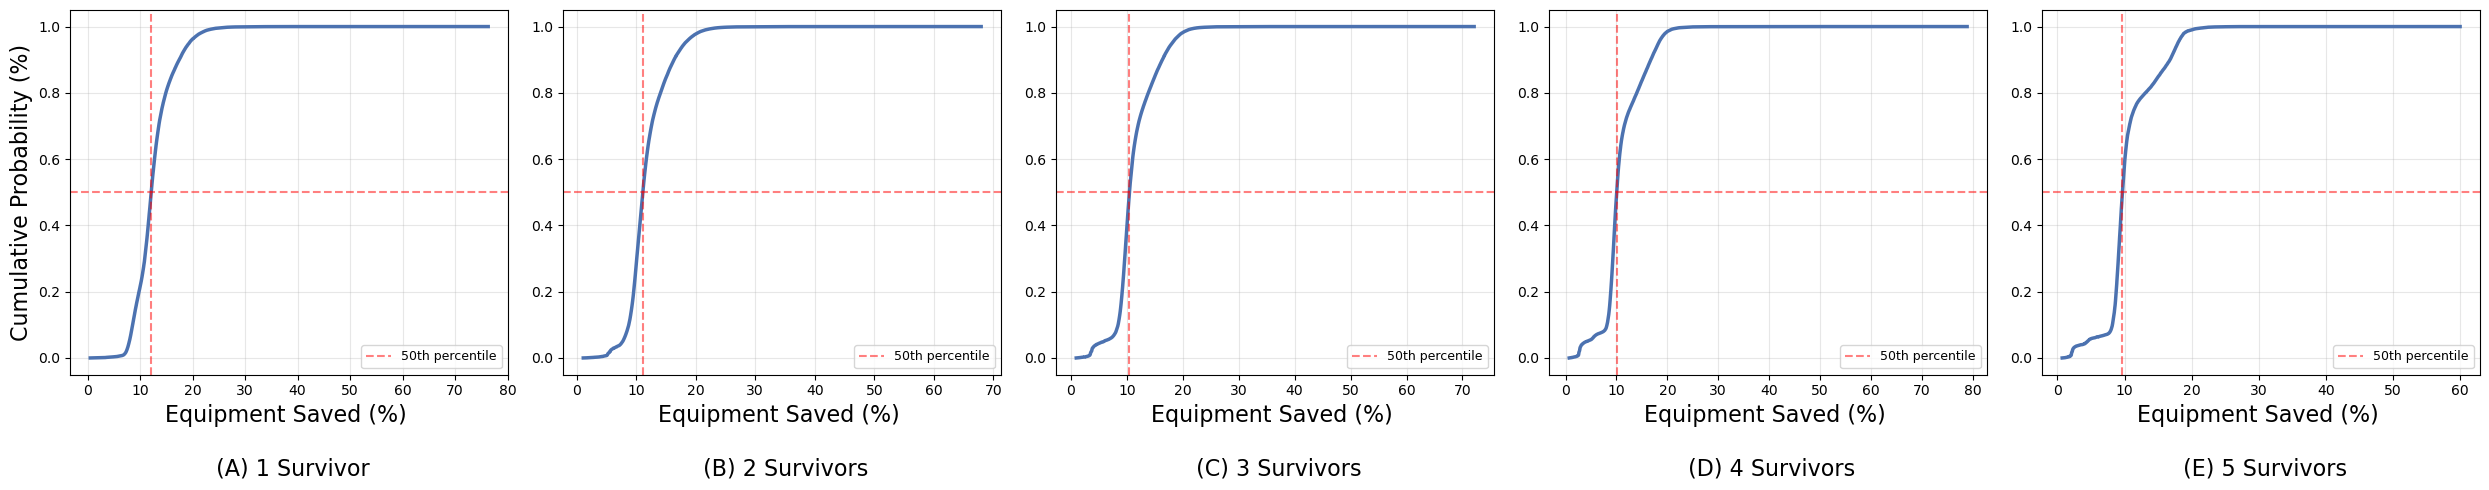


Visualizing ECDF for T side - CT Win (Elimination) (Reason 4)...


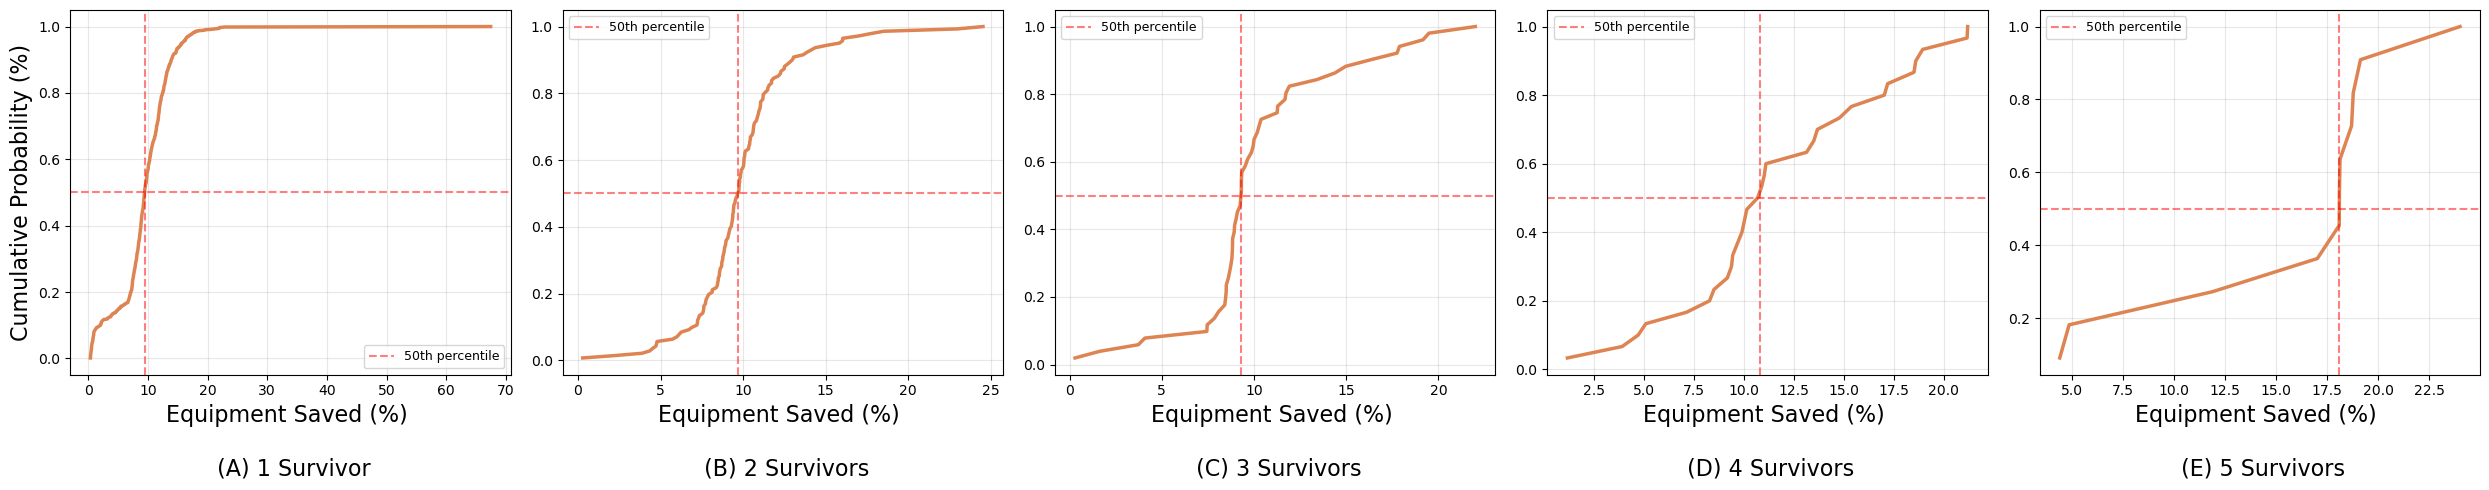


Visualizing ECDF for T side - T Win (Elimination) (Reason 2)...


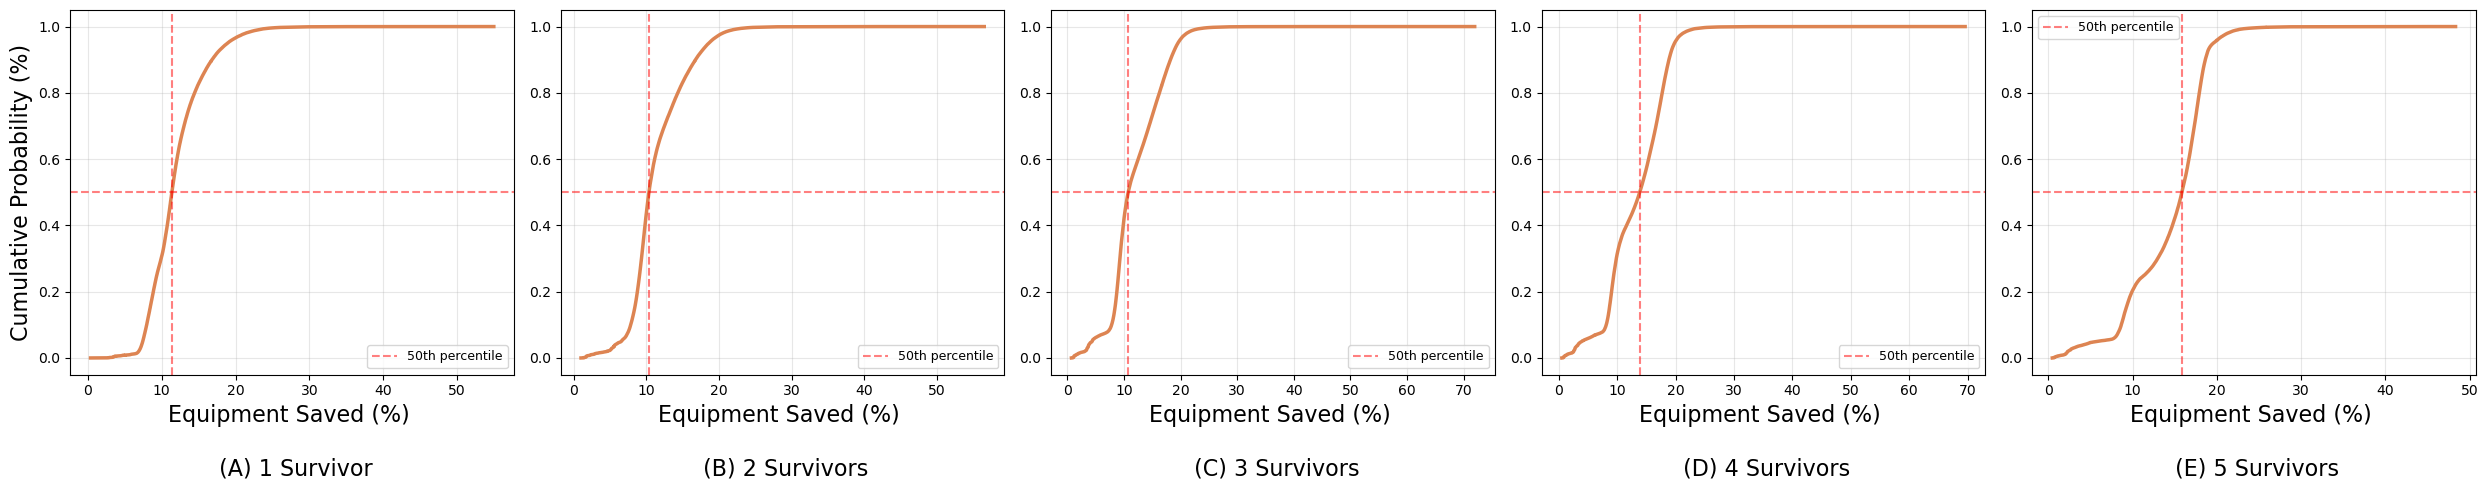


Visualizing ECDF for T side - T Win (Target Bombed) (Reason 1)...


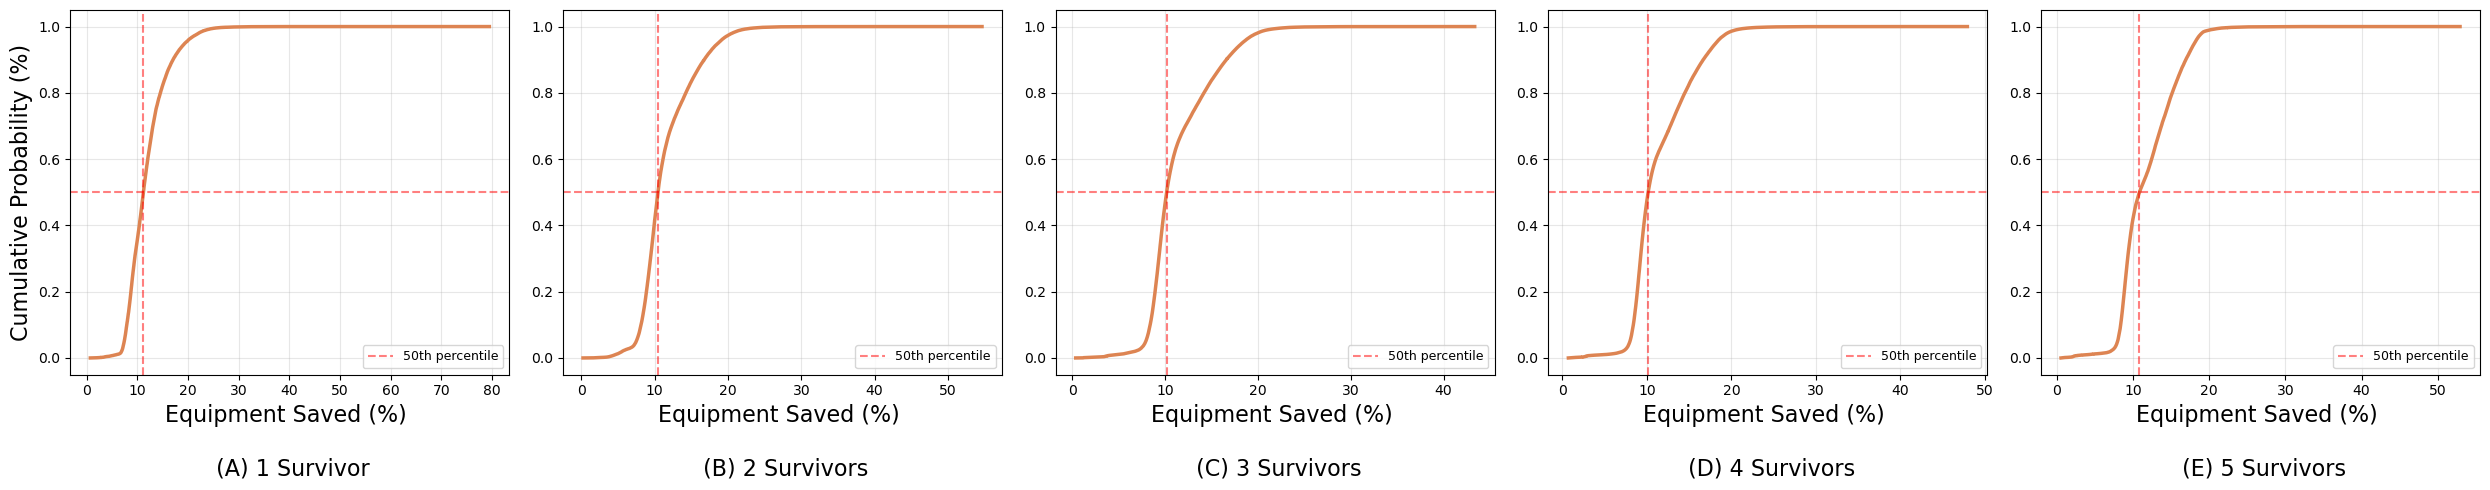


Visualizing ECDF for T side - CT Win (Defuse) (Reason 3)...


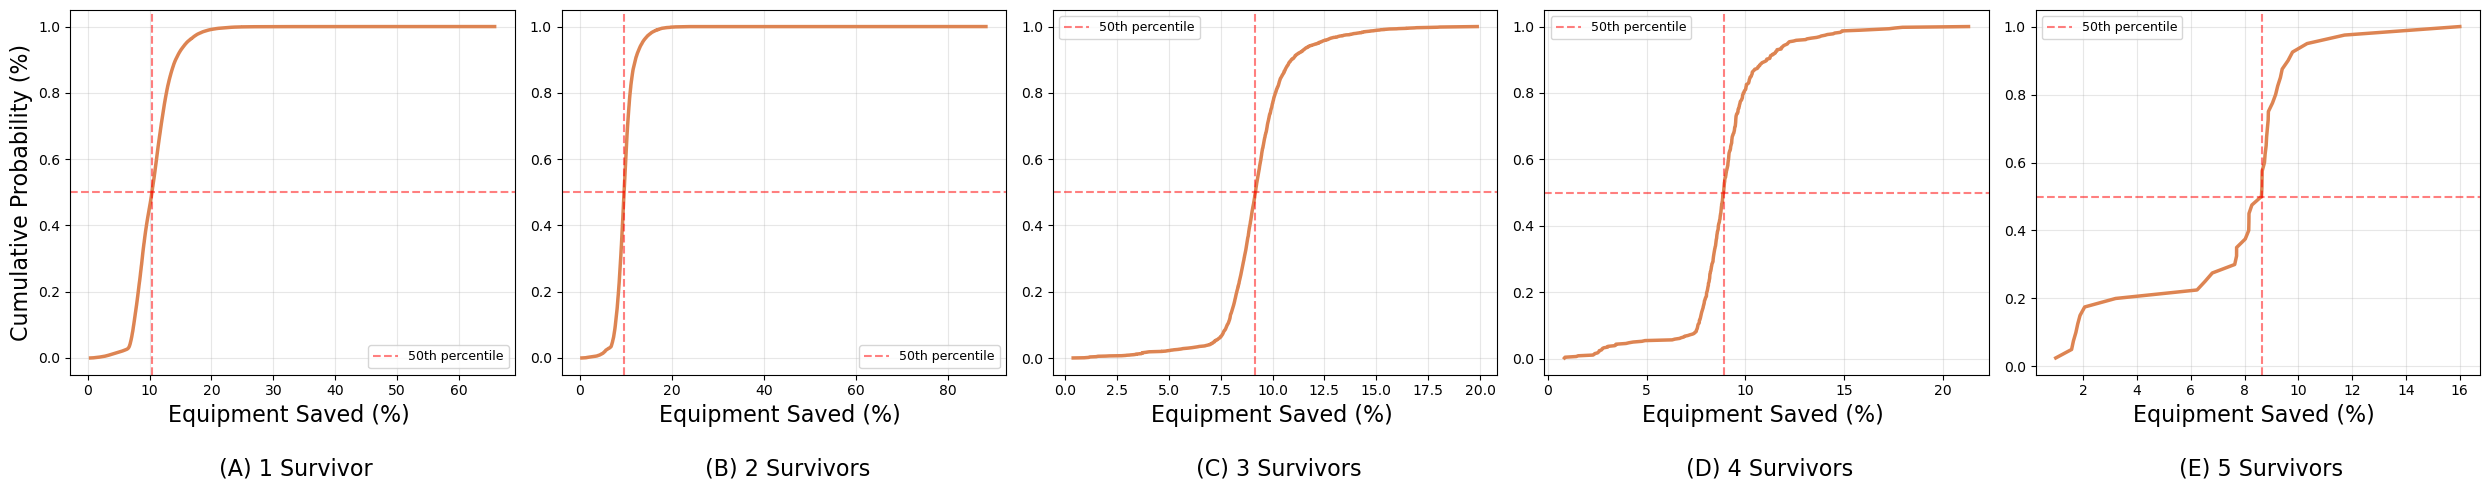

In [22]:
# Visualize ECDF for equipment saved distributions
print("📊 Creating ECDF visualizations...")
print()

for side in ['CT', 'T']:
    if side not in equipment_distributions:
        continue
    
    side_data = equipment_distributions[side]
    
    # Create visualization for each round end reason
    for reason, reason_data in side_data.items():
        if isinstance(reason, int):  # Skip if not a reason number
            reason_name = reason_data['reason_name']
            surv_dists = reason_data['survivor_distributions']
            
            if not surv_dists:
                continue
            
            # Count how many survivors have data
            n_survivors = len(surv_dists)
            
            # Create subplots: 1 row for ECDF, n_survivors columns
            fig, axes = plt.subplots(1, n_survivors, figsize=(5*n_survivors, 5))
            if n_survivors == 1:
                axes = [axes]
            
            #fig.suptitle(f'{side} Side: {reason_name} (Reason {reason})\nEquipment Saved ECDF by Survivors', fontsize=16, fontweight='bold')
            print(f"\nVisualizing ECDF for {side} side - {reason_name} (Reason {reason})...")
            
            for idx, (surv, dist_data) in enumerate(sorted(surv_dists.items())):
                # Get the actual data for plotting
                df_side = improved_regression_results[0 if side == 'CT' else 1]['df_side']
                df_plot = df_side[(df_side['round_end_reason'] == reason) & 
                                  (df_side['survivors'] == surv)]
                eq_saved_pct = df_plot['saved_per_survivor_pct'].values
                
                if len(eq_saved_pct) < 10:
                    continue
                
                #label text
                if surv == 1:
                    label = f" (A) {surv} Survivor"
                if surv == 2:
                    label = f" (B) {surv} Survivors"
                if surv == 3:
                    label = f" (C) {surv} Survivors"
                if surv == 4:
                    label = f" (D) {surv} Survivors"
                if surv == 5:
                    label = f" (E) {surv} Survivors"

                y_label = 'Cumulative Probability (%)' 

                # ECDF Plot using seaborn 'deep' palette
                ax = axes[idx]
                deep_palette = sns.color_palette('deep', n_colors=10)
                sorted_data = np.sort(eq_saved_pct)
                ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
                ax.plot(sorted_data, ecdf_y, linewidth=2.5, color=deep_palette[0] if side == 'CT' else deep_palette[1])
                ax.set_xlabel(f'Equipment Saved (%) \n\n{label}', fontsize=16)
                if surv == 1:
                    ax.set_ylabel(y_label, fontsize=16)
                # ax.set_ylabel(y_label, fontsize=16)
                #ax.set_title(f'{surv} Survivor{"s" if surv > 1 else ""}\n(n={dist_data["n_samples"]:,})\n' +
                #           f'Median: {dist_data["median"]:.1f}% | Mean: {dist_data["mean"]:.1f}%', 
                #           fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
                ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='50th percentile')
                ax.axvline(x=dist_data['median'], color='red', linestyle='--', alpha=0.5, linewidth=1.5)
                ax.legend(loc='best', fontsize=9)
            
            plt.tight_layout()
            plt.show()



In [23]:
import json

# Export all analysis results to JSON for Go ABM
print("="*80)
print("📤 EXPORTING ALL ABM DATA TO JSON")
print("="*80)
print()

REASON_NAMES = {
    1: "T Win (Target Bombed)",
    2: "T Win (Elimination)",
    3: "CT Win (Defuse)",
    4: "CT Win (Elimination)",
}

for reason_code, reason_name in REASON_NAMES.items():
    count = (detailed_df['round_end_reason'] == reason_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"   {reason_code}: {reason_name} - {count:,} rounds ({pct:.2f}%)")
print()

# Convert numpy types to native Python types for JSON
def convert_to_native_types(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    else:
        return obj

# Convert CSF percentages from string keys to integers (1-100)
def convert_csf_keys_to_int(analysis_dict):
    """Convert CSF percentage keys from any format to integers 1-100"""
    converted = {}
    for key, value in analysis_dict.items():
        if isinstance(key, str) and key.isdigit():
            int_key = int(key)
            if 1 <= int_key <= 100:
                converted[int_key] = convert_to_native_types(value)
        elif isinstance(key, int) and 1 <= key <= 100:
            converted[key] = convert_to_native_types(value)
        else:
            # Keep non-CSF keys as-is (e.g., 'CT', 'T', reason numbers)
            converted[key] = convert_to_native_types(value) if isinstance(value, dict) else value
    return converted

def interpolate_missing_csf_values(data_dict):
    """
    Fill in missing CSF percentage values by interpolating between neighbors.
    Ensures continuous CSF coverage from min to max.
    Only interpolates numeric values (probabilities, stats), not categorical data.
    """
    if not data_dict:
        return data_dict
    
    # Get available CSF percentages
    csf_values = sorted([k for k in data_dict.keys() if isinstance(k, int)])
    if len(csf_values) < 2:
        return data_dict
    
    min_csf = min(csf_values)
    max_csf = max(csf_values)
    
    # Create interpolated data for missing values
    for csf in range(min_csf, max_csf + 1):
        if csf not in data_dict:
            # Find nearest lower and upper neighbors
            lower = max([v for v in csf_values if v < csf], default=None)
            upper = min([v for v in csf_values if v > csf], default=None)
            
            if lower is not None and upper is not None:
                # Average the two neighbors
                lower_data = data_dict[lower]
                upper_data = data_dict[upper]
                
                # Deep copy structure and average numeric values
                interpolated = {}
                for key in lower_data.keys():
                    if isinstance(lower_data[key], (int, float)):
                        interpolated[key] = (lower_data[key] + upper_data[key]) / 2
                    elif isinstance(lower_data[key], dict):
                        # Recursively interpolate nested dicts
                        interpolated[key] = {}
                        for subkey in lower_data[key].keys():
                            lower_val = lower_data[key][subkey]
                            upper_val = upper_data[key].get(subkey, lower_val)
                            
                            if isinstance(lower_val, (int, float)):
                                interpolated[key][subkey] = (lower_val + upper_val) / 2
                            elif isinstance(lower_val, dict):
                                interpolated[key][subkey] = {}
                                for subsubkey in lower_val.keys():
                                    lower_subval = lower_val[subsubkey]
                                    upper_subval = upper_val.get(subsubkey, lower_subval) if isinstance(upper_val, dict) else lower_subval
                                    
                                    # Don't interpolate if key contains 'reason' or 'name' (categorical data)
                                    if 'reason' in subsubkey.lower() or 'name' in subsubkey.lower():
                                        interpolated[key][subkey][subsubkey] = lower_subval
                                    elif isinstance(lower_subval, (int, float)):
                                        interpolated[key][subkey][subsubkey] = (lower_subval + upper_subval) / 2
                                    else:
                                        # Copy non-numeric values (like reason codes, names) from lower
                                        interpolated[key][subkey][subsubkey] = lower_subval
                            else:
                                # Copy non-numeric values (like reason codes, names) from lower
                                interpolated[key][subkey] = lower_val
                    else:
                        # Copy non-numeric values from lower
                        interpolated[key] = lower_data[key]
                
                # If this has reason_distribution, rebuild cumulative_distribution from it
                if 'reason_distribution' in interpolated and 'cumulative_distribution' in lower_data:
                    cumulative_reason_dist = {}
                    cumulative_prob = 0.0
                    # Sort by reason code for consistent ordering
                    sorted_reasons = sorted(interpolated['reason_distribution'].keys())
                    for reason_code in sorted_reasons:
                        reason_info = interpolated['reason_distribution'][reason_code]
                        probability = reason_info['probability']
                        
                        # Skip if probability is 0
                        if probability == 0:
                            continue
                            
                        cumulative_prob += probability
                        cumulative_key = int(np.ceil(cumulative_prob * 100))
                        # Only set if this key doesn't exist yet (first entry wins)
                        if cumulative_key not in cumulative_reason_dist:
                            cumulative_reason_dist[cumulative_key] = {
                                'reason': int(reason_code),
                                'reason_name': reason_info['reason_name'],
                                'cumulative_probability': cumulative_prob
                            }
                    interpolated['cumulative_distribution'] = cumulative_reason_dist
                
                # Mark interpolated data with n_rounds = 0 (indicating estimated values)
                if 'n_rounds' in interpolated:
                    interpolated['n_rounds'] = 0
                if 'n_samples' in interpolated:
                    interpolated['n_samples'] = 0
                
                # Also mark count fields in nested structures (like reason_distribution)
                for key in interpolated.keys():
                    if isinstance(interpolated[key], dict):
                        # Ensure cumulative_lookup values are integers (survivor counts)
                        if key == 'cumulative_lookup':
                            for lookup_key in interpolated[key].keys():
                                interpolated[key][lookup_key] = int(round(interpolated[key][lookup_key]))
                        
                        for subkey in interpolated[key].keys():
                            if isinstance(interpolated[key][subkey], dict):
                                if 'count' in interpolated[key][subkey]:
                                    interpolated[key][subkey]['count'] = 0
                
                data_dict[csf] = interpolated
    
    # Return sorted by CSF percentage
    return dict(sorted(data_dict.items()))

print("🔹 Converting round end reason analysis...")
round_end_reason_export = {}
for side, side_data in round_end_reason_analysis.items():
    round_end_reason_export[side] = {}
    for csf_pct, csf_data in side_data.items():
        csf_converted = convert_csf_keys_to_int({csf_pct: csf_data})[csf_pct]
        
        # Build cumulative distribution for round end reasons (for fast sampling)
        cumulative_reason_dist = {}
        if 'reason_distribution' in csf_converted:
            cumulative_prob = 0.0
            # Sort by reason code for consistent ordering
            sorted_reasons = sorted(csf_converted['reason_distribution'].keys())
            for reason_code in sorted_reasons:
                reason_info = csf_converted['reason_distribution'][reason_code]
                probability = reason_info['probability']
                
                # Skip if probability is 0
                if probability == 0:
                    continue
                    
                cumulative_prob += probability
                # Use cumulative probability * 100 as integer key (0-100), always round up
                cumulative_key = int(np.ceil(cumulative_prob * 100))
                # Only set if this key doesn't exist yet (first entry wins)
                if cumulative_key not in cumulative_reason_dist:
                    cumulative_reason_dist[cumulative_key] = {
                        'reason': int(reason_code),  # Ensure integer without decimal
                        'reason_name': reason_info['reason_name'],
                        'cumulative_probability': cumulative_prob
                    }
        
        # Reorganize: cumulative distribution first for O(1) sampling, then individual probabilities, then metadata
        reorganized = {
            'cumulative_distribution': cumulative_reason_dist,
            'reason_distribution': csf_converted.get('reason_distribution', {}),
            'n_rounds': csf_converted.get('n_rounds', 0)
        }
        
        round_end_reason_export[side][csf_pct] = reorganized
    
    # Interpolate missing CSF values
    print(f"   Interpolating missing CSF values for {side} side...")
    round_end_reason_export[side] = interpolate_missing_csf_values(round_end_reason_export[side])


print("🔹 Converting bomb planted analysis...")
bomb_planted_export = {}
for side, side_data in bomb_planted_analysis.items():
    bomb_planted_export[side] = {}
    for csf_pct, csf_data in side_data.items():
        csf_converted = convert_csf_keys_to_int({csf_pct: csf_data})[csf_pct]
        
        # Simplified: only store bomb_planted_probability (for reason 2/T elimination)
        # ABM can derive not_planted as 1 - planted
        bomb_planted_export[side][csf_pct] = csf_converted.get('bomb_planted_probability', 0)
    
    # Interpolate missing CSF values
    print(f"   Interpolating missing CSF values for {side} side...")
    csf_values = sorted([k for k in bomb_planted_export[side].keys() if isinstance(k, int)])
    if len(csf_values) >= 2:
        min_csf = min(csf_values)
        max_csf = max(csf_values)
        for csf in range(min_csf, max_csf + 1):
            if csf not in bomb_planted_export[side]:
                lower = max([v for v in csf_values if v < csf], default=None)
                upper = min([v for v in csf_values if v > csf], default=None)
                if lower is not None and upper is not None:
                    bomb_planted_export[side][csf] = (bomb_planted_export[side][lower] + bomb_planted_export[side][upper]) / 2
        # Sort by CSF percentage
        bomb_planted_export[side] = dict(sorted(bomb_planted_export[side].items()))


print("🔹 Converting survivor analysis...")
survivor_distributions_export = {}
for side, side_data in survivor_analysis.items():
    survivor_distributions_export[side] = {}
    for reason, reason_data in side_data.items():
        survivor_distributions_export[side][reason] = {
            'reason_name': reason_data['reason_name'],
            'csf_distributions': {}
        }
        
        for csf_pct, csf_data in reason_data['csf_distributions'].items():
            # Create cumulative lookup table for fast sampling
            cumulative_lookup = {}
            survivor_probs = csf_data['survivor_probabilities']
            
            cumulative_prob = 0.0
            for n_survivors in range(0, 6):
                prob = survivor_probs.get(n_survivors, {}).get('probability', 0)
                cumulative_prob += prob
                
                # Map cumulative probability % (0-100) to survivor count
                cum_key = int(np.ceil(cumulative_prob * 100))
                if cum_key not in cumulative_lookup:
                    cumulative_lookup[cum_key] = n_survivors
            
            # Reorganize: cumulative lookup first for O(1) sampling
            reorganized_survs = {
                'cumulative_lookup': cumulative_lookup,
                'survivor_probabilities': convert_to_native_types(survivor_probs),
                'cumulative_distribution': convert_to_native_types(csf_data['cumulative_distribution']),
                'n_rounds': csf_data['n_rounds']
            }
            
            survivor_distributions_export[side][reason]['csf_distributions'][csf_pct] = reorganized_survs
        
        # Interpolate missing CSF values
        print(f"   Interpolating missing CSF values for {side} side, reason {reason}...")
        survivor_distributions_export[side][reason]['csf_distributions'] = interpolate_missing_csf_values(
            survivor_distributions_export[side][reason]['csf_distributions']
        )


print("🔹 Converting equipment saved distributions...")
equipment_distributions_export = {}
for side, side_data in equipment_distributions.items():
    equipment_distributions_export[side] = {}
    for reason, reason_data in side_data.items():
        reason_export = convert_to_native_types(reason_data)
            
        # Reorganize survivor distributions: ECDF lookup map first, then full ECDF, then stats
        if 'survivor_distributions' in reason_export:
            reorganized_survs = {}
            for surv_count, surv_data in reason_export['survivor_distributions'].items():
                ecdf = surv_data.get('ecdf', {})
                
                # Build ECDF lookup map: cumulative_probability * 100 -> equipment_value
                # This allows O(1) sampling: random(0-100) -> equipment value
                ecdf_lookup = {}
                if 'x' in ecdf and 'y' in ecdf:
                    for x_val, y_val in zip(ecdf['x'], ecdf['y']):
                        # Skip if probability is 0
                        if y_val == 0:
                            continue
                            
                        y_key = int(np.ceil(y_val * 100))  # Convert probability to 0-100 integer, round up
                        # Only set if this key doesn't exist yet (first entry wins)
                        if y_key not in ecdf_lookup:
                            ecdf_lookup[y_key] = x_val
                
                reorganized_survs[surv_count] = {
                    'ecdf_lookup': ecdf_lookup,  # Fast O(1) sampling: random(0-100) -> equipment %
                    'ecdf': ecdf,                 # Full ECDF for reference
                    'mean': surv_data.get('mean', 0),
                    'median': surv_data.get('median', 0),
                    'std': surv_data.get('std', 0),
                    'min': surv_data.get('min', 0),
                    'max': surv_data.get('max', 0),
                    'q25': surv_data.get('q25', 0),
                    'q75': surv_data.get('q75', 0),
                    'n_samples': surv_data.get('n_samples', 0)
                }
            reason_export['survivor_distributions'] = reorganized_survs
        
        
        equipment_distributions_export[side][reason] = reason_export

# Calculate global CSF ranges across all distributions
all_csf_values = set()
for side in ['CT', 'T']:
    if side in round_end_reason_export:
        all_csf_values.update(round_end_reason_export[side].keys())
    if side in bomb_planted_export:
        all_csf_values.update(bomb_planted_export[side].keys())

# Filter to only integer CSF values and get min/max
csf_integers = sorted([k for k in all_csf_values if isinstance(k, int)])
global_csf_min = min(csf_integers) if csf_integers else None
global_csf_max = max(csf_integers) if csf_integers else None

# Build optimized export structure
export_data = {
    "metadata": {
        "csf_r_value": float(r_optimal),
        "csf_range": "1-100 (integer percentages, CT win probability)",
        "csf_formula": "P(CT win) = CT_equipment^r / (CT_equipment^r + T_equipment^r)",
        "export_date": str(pd.Timestamp.now().date()),
        "total_rounds": len(detailed_df),
        "round_end_reason_mapping": REASON_NAMES,
        # Add global CSF range for quick bounds checking
        "csf_ranges": {
            "min": global_csf_min,
            "max": global_csf_max
        }
    },
    "distributions": {
        "round_end_reason": round_end_reason_export,
        "bomb_planted": bomb_planted_export,
        "survivors": survivor_distributions_export,
        "equipment_saved": equipment_distributions_export
    }
}


# Save to JSON
output_file = 'distributions.json'
with open(output_file, 'w') as f:
    json.dump(export_data, f, indent=2)

print("="*80)
print(f"✅ EXPORT COMPLETE: {output_file}")
print("="*80)
print()
print(f"📊 Exported Data Summary:")
print(f"   • Round End Reasons: {sum(len(round_end_reason_export[s]) for s in round_end_reason_export)} CSF entries")
print(f"   • Survivors: {sum(sum(len(survivor_distributions_export[s][r]['csf_distributions']) for r in survivor_distributions_export[s]) for s in survivor_distributions_export)} CSF entries")
print(f"   • Bomb Planted: {sum(len(bomb_planted_export[s]) for s in bomb_planted_export)} CSF entries")
print(f"   • Equipment Saved: {sum(len(equipment_distributions_export[s]) for s in equipment_distributions_export)} reason entries")
print()
print("💡 Use this JSON file in your Go ABM for realistic round simulations")


📤 EXPORTING ALL ABM DATA TO JSON

   1: T Win (Target Bombed) - 404,616 rounds (15.73%)
   2: T Win (Elimination) - 841,615 rounds (32.71%)
   3: CT Win (Defuse) - 403,435 rounds (15.68%)
   4: CT Win (Elimination) - 923,305 rounds (35.88%)

🔹 Converting round end reason analysis...
   Interpolating missing CSF values for CT side...
   Interpolating missing CSF values for T side...
🔹 Converting bomb planted analysis...
   Interpolating missing CSF values for T side...
🔹 Converting survivor analysis...
   Interpolating missing CSF values for CT side, reason 4...
   Interpolating missing CSF values for CT side, reason 2...
   Interpolating missing CSF values for CT side, reason 1...
   Interpolating missing CSF values for CT side, reason 3...
   Interpolating missing CSF values for T side, reason 4...
   Interpolating missing CSF values for T side, reason 2...
   Interpolating missing CSF values for T side, reason 1...
   Interpolating missing CSF values for T side, reason 3...
🔹 Convert